# UK Retail Consumption Demand Forecasting 

This notebook develops a demand forecasting system for UK retail consumption using Prophet and compares it with other time series models (ARIMA, LSTM with PyTorch, XGBoost).

## Objective
- Forecast UK household demand using Prophet and compare with ARIMA, LSTM, and XGBoost
- Use ONS consumer trend datasets (quarterly format, by COICOP category)
- Evaluate using MAPE, MAE, RMSE
- Save the final Prophet model for use in a Streamlit app

## 1. Importing Libraries
Importing required libraries in a Python 3.13.X environment.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re, glob, pickle, warnings
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from tensorflow.keras import layers, models
import holidays
import requests
from datetime import datetime
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Data Loading and Preprocessing

First, we'll load and clean the three Excel sheets from the ONS consumer trend datasets. The data is quarterly.


✅ Shape: (1356, 7)
Nulls per column:
 ds                   0
coicop_base          0
volume               0
deflator             0
price                0
unemployment_rate    0
is_holiday           0
dtype: int64
COICOP codes present: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Quarters from: 1997-01-01 to 2025-01-01


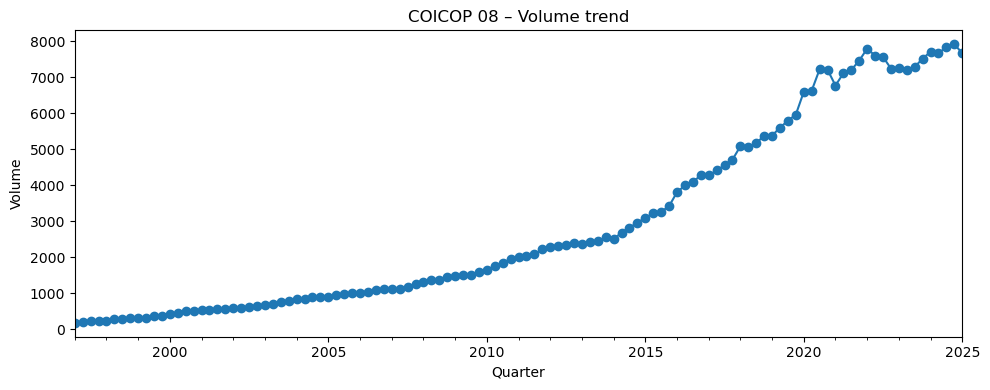

✅ Saved merged dataset to /Users/mkcgoud/Desktop/Dessertation/UK_DEMAND_FORECAST_Final/notebooks/Cleaned_Coicop_Data.csv
Final row count: 1356


In [ ]:
import pandas as pd
from pathlib import Path
import requests

VOLUME_FILE   = "CTCVMSA.xlsx"
PRICE_FILE    = "CTCPSA.xlsx"
DEFLATOR_FILE = "CTIDSA.xlsx"
UNEMP_FILE    = "UKUNRATE.csv"

CODES = [f"{i:02d}" for i in range(1, 13)]  # COICOP codes '01' to '12' used to filter major categories 

def parse_ons_table_b(file_path):
    xl = pd.ExcelFile(file_path) #Loading Excel file
    dfs = []
    for sheet_name in xl.sheet_names:
        df_raw = xl.parse(sheet_name, header=None)
        # Find the 2nd occurrence of "COICOP identifier code" as the first table in the sheet is not Seasonally adjusted
        coicop_rows = df_raw[df_raw[0].astype(str).str.contains('COICOP identifier code', na=False)].index
        if len(coicop_rows) < 2:
            continue  # if there is no Table (b) in this sheet "Skip sheet"
        coicop_row_idx = coicop_rows[1]
        cdid_row_idx = coicop_row_idx + 1
        coicop_codes = df_raw.loc[coicop_row_idx].values
        cdid_codes = df_raw.loc[cdid_row_idx].values
        # Finding first data row in(YYYY Qn) format after (b) header
        q_data_start = df_raw.index[(df_raw.index > cdid_row_idx) &
                                    df_raw[0].astype(str).str.match(r"^\d{4} Q[1-4]$")].min()
        if pd.isna(q_data_start):
            continue
        data = df_raw.iloc[q_data_start:, :len(coicop_codes)]
        # Set column names
        col_names = ['period']
        for idx in range(1, len(coicop_codes)):
            cdid = str(cdid_codes[idx]) if str(cdid_codes[idx]) != 'nan' else str(coicop_codes[idx])
            col_names.append(cdid)
        data.columns = col_names
        # Pivot table format to long format
        value_cols = col_names[1:]
        df_long = data.melt(id_vars=['period'], value_vars=value_cols, var_name='series', value_name='y')
        # Quarter period(YYYY Qn) to date(YYYY-MM-DD)
        def safe_period_to_date(x):
            try:
                year = x[:4]
                q = x[-1]
                if q.isdigit():
                    return pd.to_datetime(f"{year}-{(int(q)*3)-2:02d}-01")
                else:
                    return pd.NaT
            except Exception:
                return pd.NaT
        df_long['ds'] = df_long['period'].apply(safe_period_to_date)
        mapping = {str(cdid_codes[idx]) if str(cdid_codes[idx]) != 'nan' else str(coicop_codes[idx]): str(coicop_codes[idx]) for idx in range(1, len(coicop_codes))}
        df_long['coicop_base'] = df_long['series'].map(mapping)
        #FILTER: Only keeps rows where coicop_base is top-level (two digits, no decimal or dot)
        df_long = df_long[df_long['coicop_base'].astype(str).str.fullmatch(r"\d{2}")]
        df_long = df_long[['ds', 'coicop_base', 'y']].dropna().drop_duplicates().reset_index(drop=True)
        dfs.append(df_long)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        print(f"❌ No Table (b) found in {file_path}")
        return pd.DataFrame()

# --- Loads all data for all the sheets/files ---
volumes_df  = parse_ons_table_b(VOLUME_FILE).rename(columns={'y': 'volume'})
deflator_df = parse_ons_table_b(DEFLATOR_FILE).rename(columns={'y': 'deflator'})
price_df    = parse_ons_table_b(PRICE_FILE).rename(columns={'y': 'price'})

# --- Merge Dataframes based on [ds, coicop_base] using left join ---
master = (
    volumes_df
    .merge(deflator_df, on=['ds', 'coicop_base'], how='left')
    .merge(price_df,    on=['ds', 'coicop_base'], how='left')
)

# --- Adding Unemployment rate ---
def parse_quarter(qstr):
    year, q = int(qstr[:4]), int(qstr[-1])
    return pd.to_datetime(f"{year}-{(q*3)-2:02d}-01")
unemp = pd.read_csv(UNEMP_FILE)
unemp['ds'] = unemp['Quarter'].apply(parse_quarter)
master = master.merge(unemp[['ds', 'UNRATE']], on='ds', how='left').rename(columns={'UNRATE': 'unemployment_rate'})

# --- Adding UK Holidays (gov.uk API, 1 if holiday, 0 else) ---
def load_uk_holidays():
    try:
        r = requests.get("https://www.gov.uk/bank-holidays.json", timeout=10)
        events = r.json()['england-and-wales']['events']
        hol_df = pd.DataFrame(events)[['date']]
        hol_df['ds'] = pd.to_datetime(hol_df['date'])
        hol_df['is_holiday'] = 1
        return hol_df[['ds', 'is_holiday']]
    except Exception as e:
        print("Could not fetch holidays:", e)
        return pd.DataFrame(columns=['ds', 'is_holiday'])

holidays_df = load_uk_holidays()
master = master.merge(holidays_df, on='ds', how='left')
master['is_holiday'] = master['is_holiday'].fillna(0).astype(int)

# --- Dropping duplicates and sort for safety ---
master = master.drop_duplicates(subset=['ds', 'coicop_base']).sort_values(['coicop_base', 'ds']).reset_index(drop=True)

# --- basic EDA / Summary ---
print(f"\n✅ Shape: {master.shape}")
print("Nulls per column:\n", master.isnull().sum())
print("COICOP codes present:", sorted(master['coicop_base'].unique()))
print("Quarters from:", master['ds'].min().date(), "to", master['ds'].max().date())

# Quick trend plot for COICOP 08 (change as needed)
import matplotlib.pyplot as plt
sample_code = "08"
plt.figure(figsize=(10,4))
master[master['coicop_base']==sample_code].sort_values("ds").plot(
    x="ds", y="volume", marker='o', legend=False, ax=plt.gca())
plt.title(f"COICOP {sample_code} – Volume trend")
plt.xlabel("Quarter"); plt.ylabel("Volume"); plt.tight_layout(); plt.show()

# Saves the master DataFrame to Cleaned_Coicop_Data.csv
out_path = Path("Cleaned_Coicop_Data.csv")
master.to_csv(out_path, index=False)
print(f"✅ Saved merged dataset to {out_path.resolve()}")

print(f"Final row count: {master.shape[0]}")


## 3. Exploratory Data Analysis (EDA)

Shape: (1356, 7)
Columns: ['ds', 'coicop_base', 'volume', 'deflator', 'price', 'unemployment_rate', 'is_holiday']
Date range: 1997-01-01 to 2025-01-01
Unique COICOP codes: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


Column  Null count
0                 ds           0
1        coicop_base           0
2             volume           0
3           deflator           0
4              price           0
5  unemployment_rate           0
6         is_holiday           0

coicop_base  Rows
0           01   113
1           02   113
2           03   113
3           04   113
4           05   113
5           06   113
6           07   113
7           08   113
8           09   113
9           10   113
10          11   113
11          12   113

count                           mean                  min                  25%  \
ds                    1356  2010-12-31 08:29:44.070796544  1997-01-01 00:00:00  2004-01-01 00:00:00   
volume            1,356.00                      27,475.16               173.00             8,620.25   
deflator          1,356.00                         110.63                21.70                67.50   
price             1,356.00                      21,936.79             1,380.00             8,103.75   
unemployment_rate 1,356.00                           5.54                 3.70                 4.60   
is_holiday        1,356.00                           0.03                 0.00                 0.00   

                                   50%                  75%                  max       std  
ds                 2011-01-01 00:00:00  2018-01-01 00:00:00  2025-01-01 00:00:00       NaN  
volume                       18,921.50            37,136.50           101,363.00 23,368.67  
deflator                         83.10                92.62             1,946.80    164.44  
price                        16,363.50            29,253.50           115,295.00 19,473.68  
unemployment_rate                 5.20                 6.30                 8.40      1.31  
is_holiday                        0.00                 0.00                 1.00      0.16

volume  deflator  price  unemployment_rate  is_holiday
volume               1.00     -0.22   0.95              -0.06        0.03
deflator            -0.22      1.00  -0.15               0.03       -0.00
price                0.95     -0.15   1.00              -0.15        0.11
unemployment_rate   -0.06      0.03  -0.15               1.00       -0.15
is_holiday           0.03     -0.00   0.11              -0.15        1.00

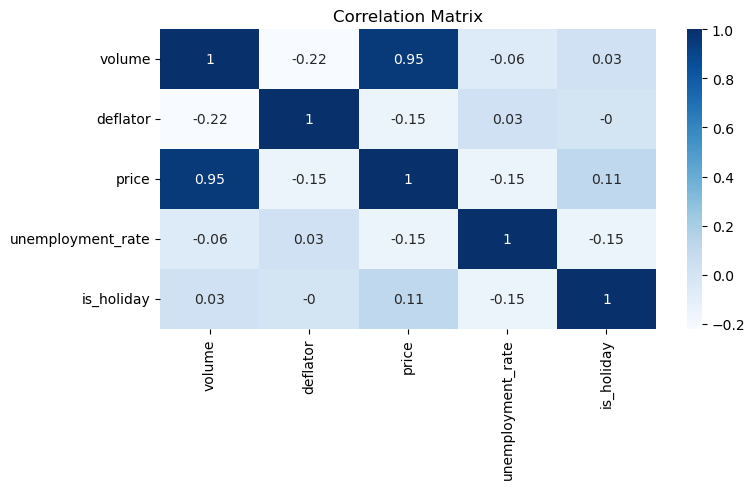

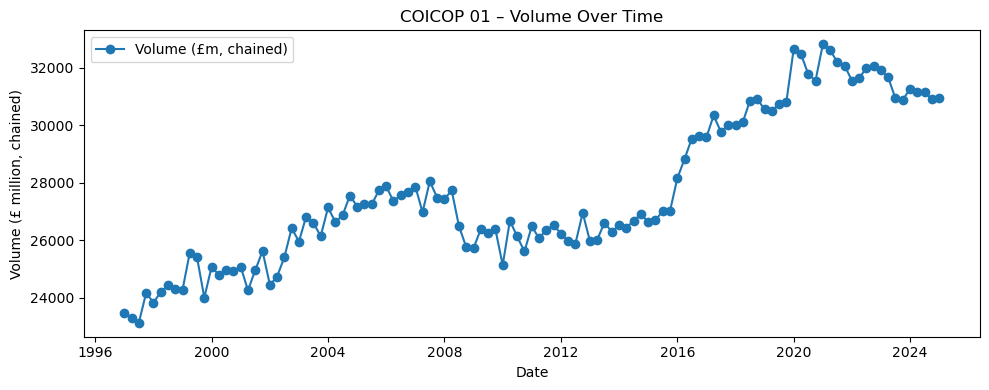

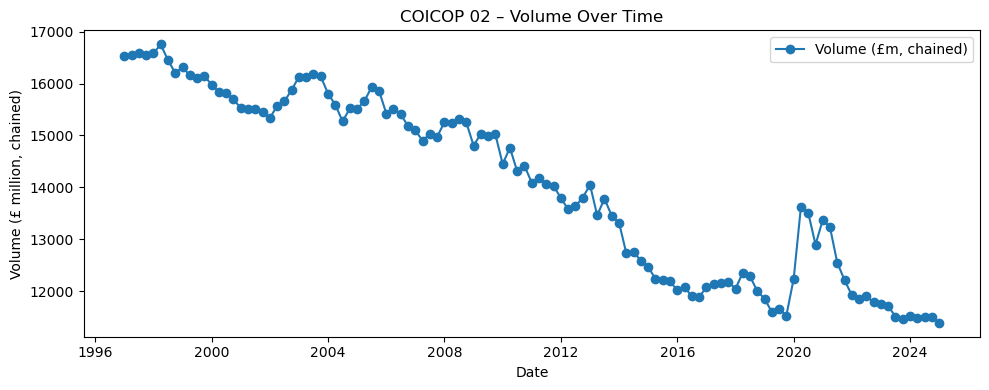

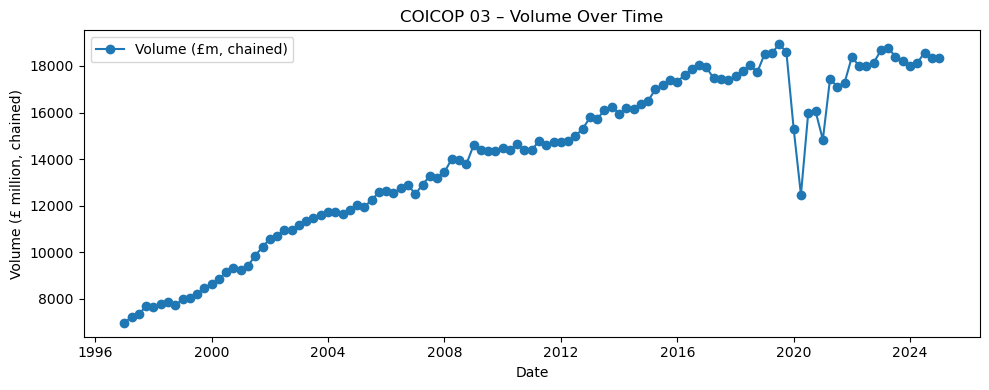

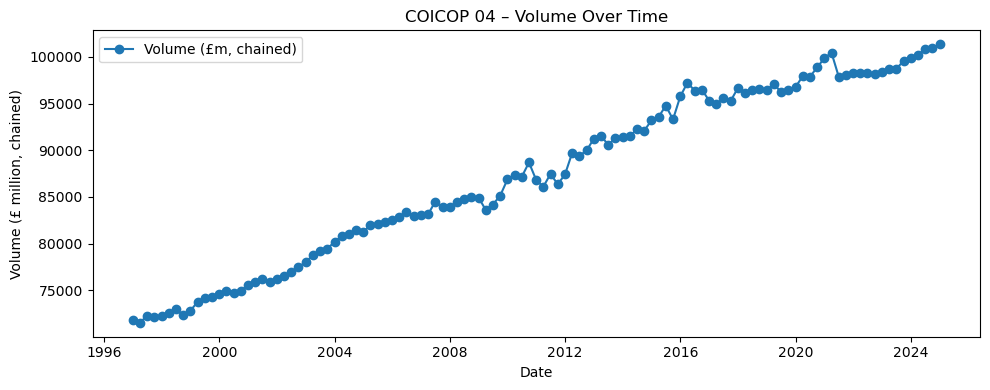

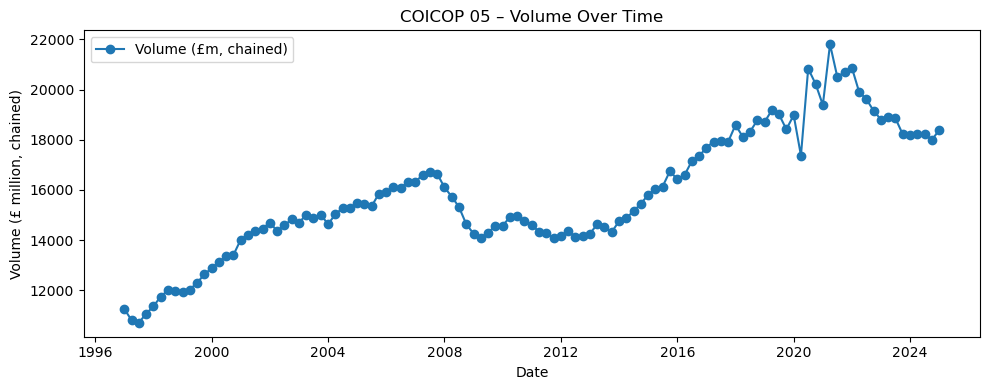

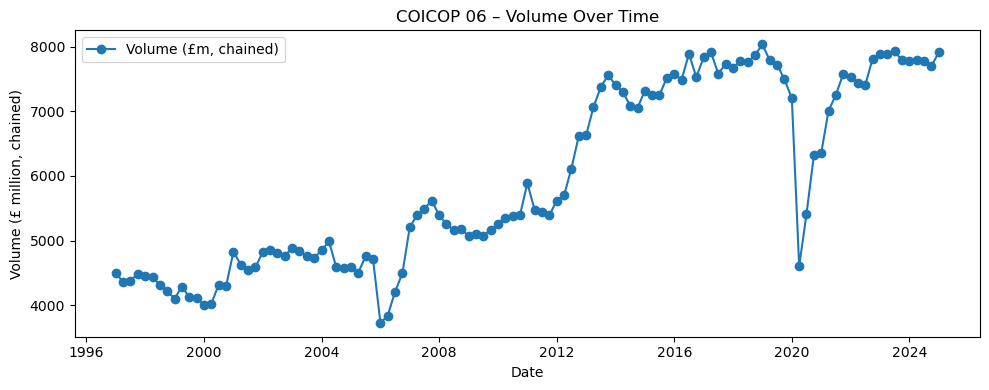

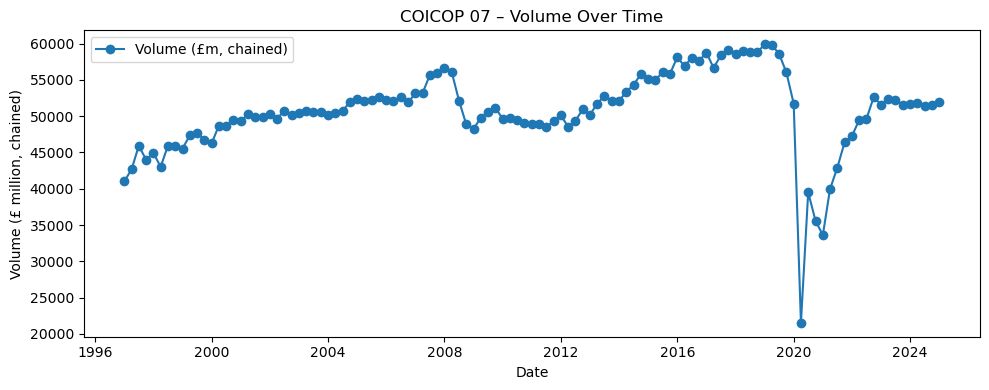

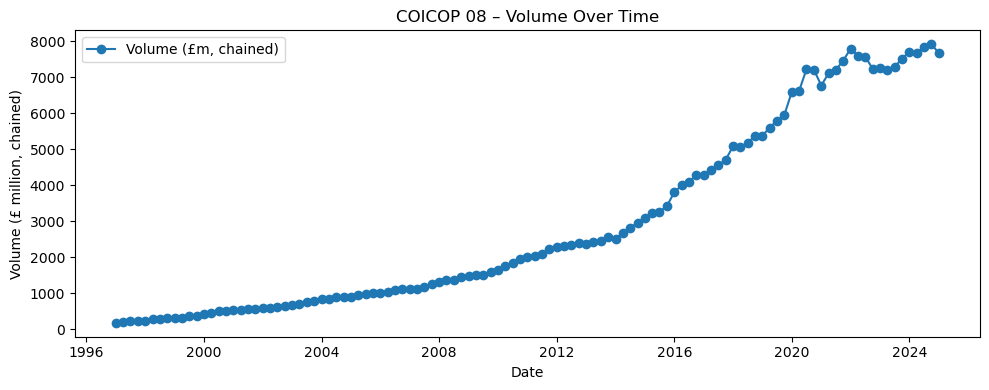

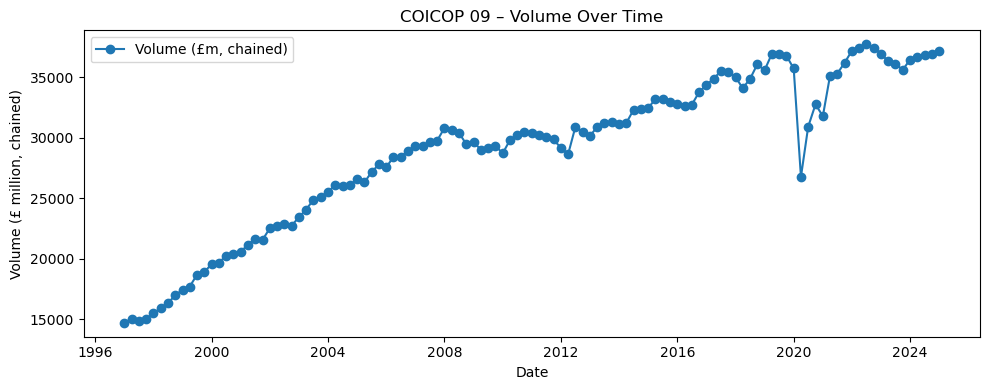

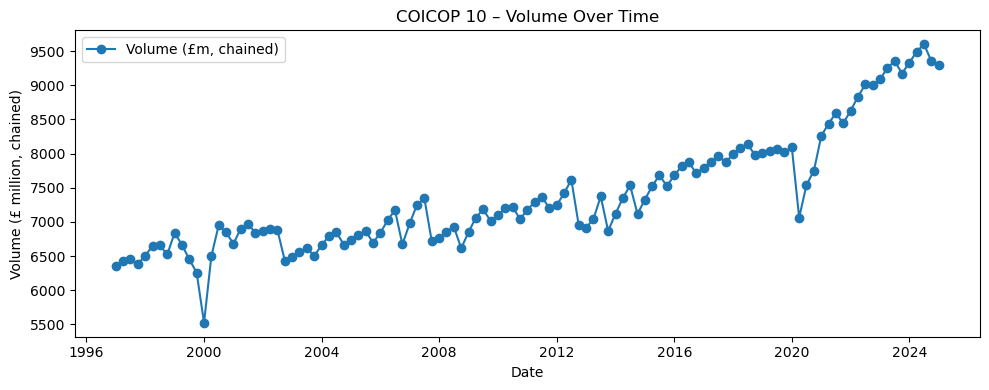

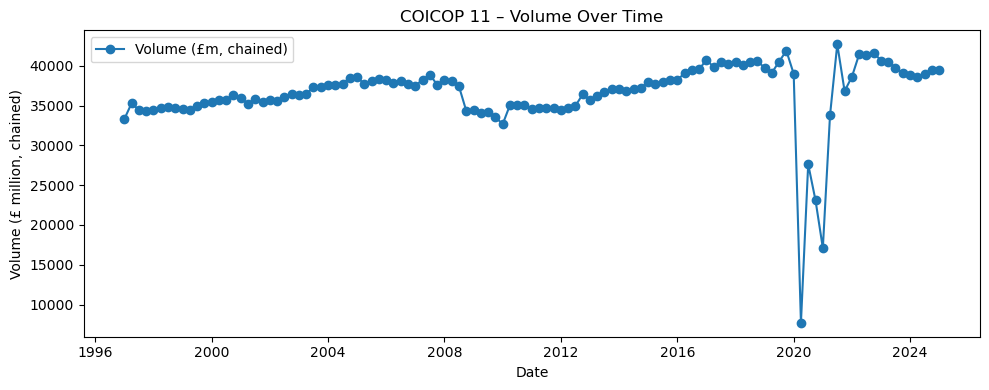

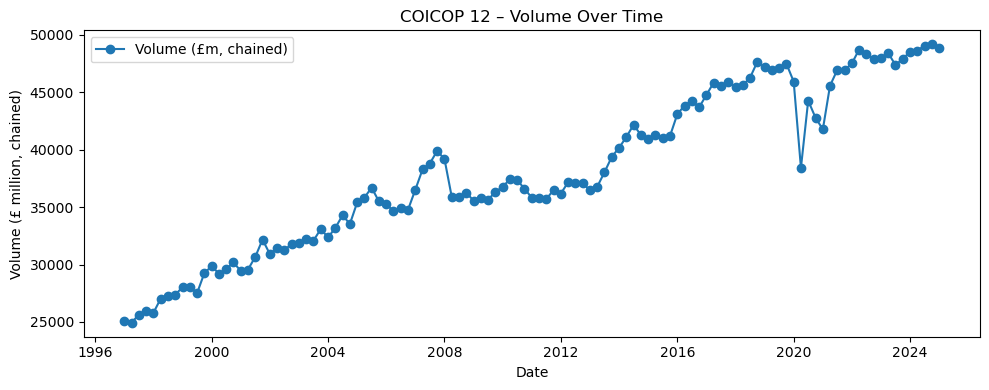

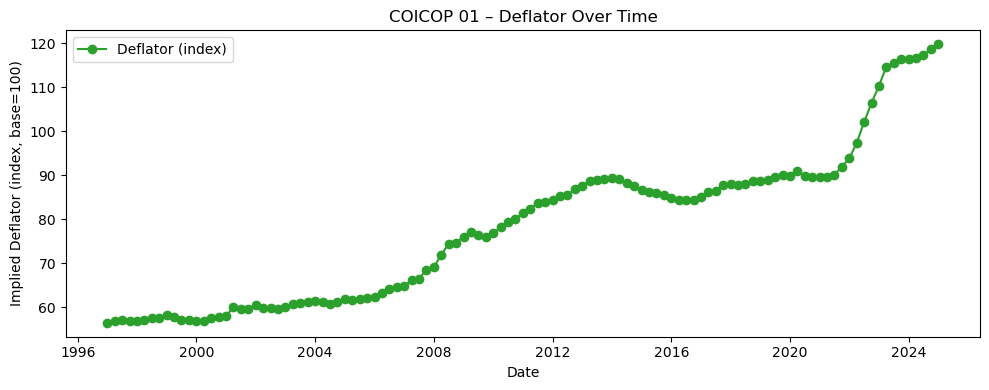

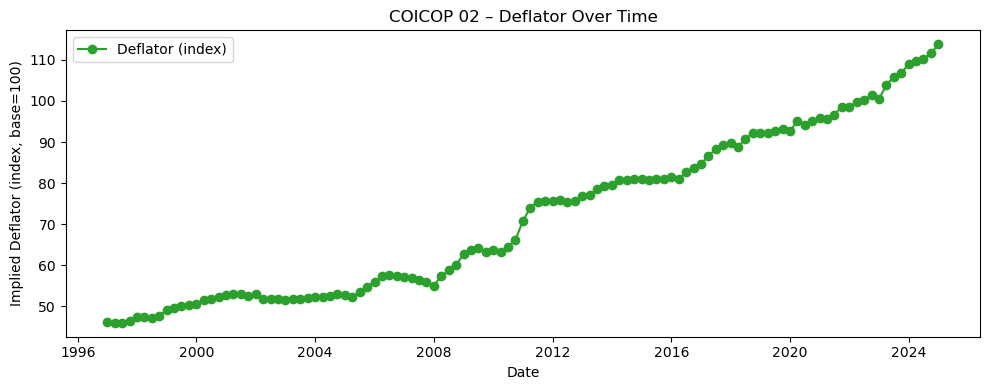

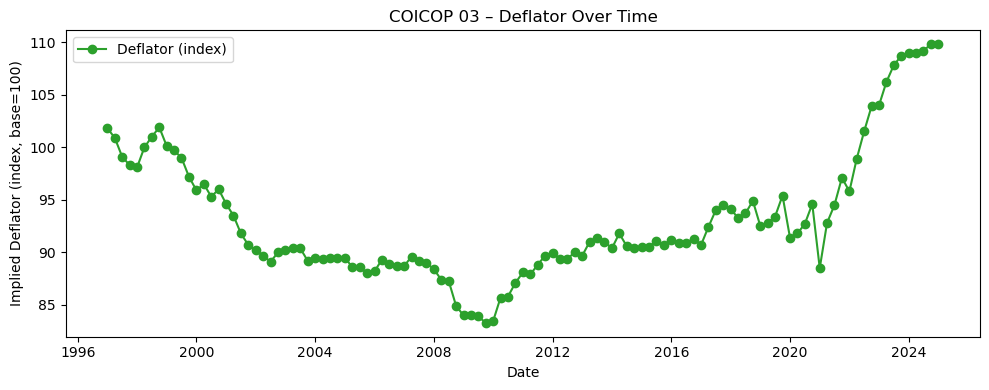

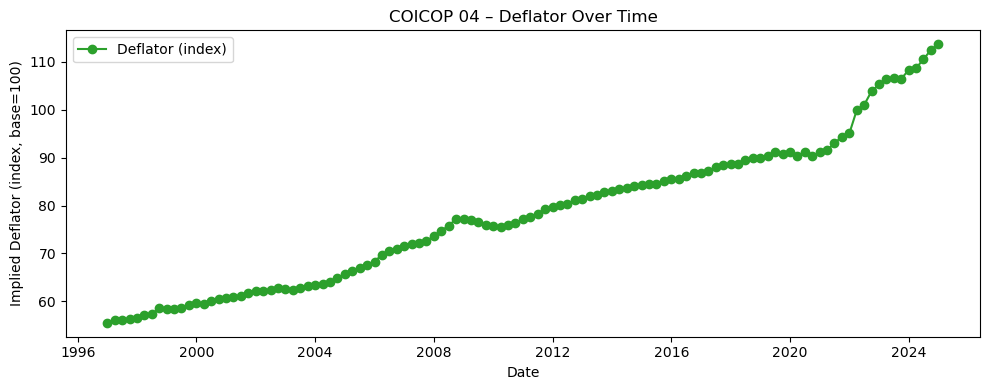

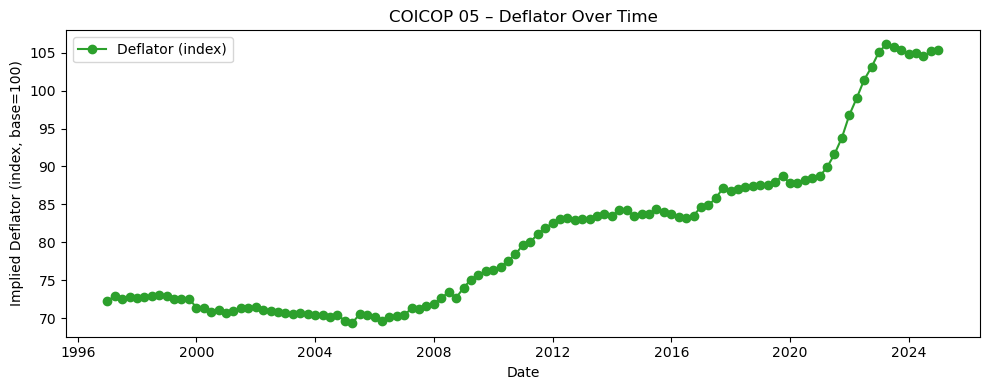

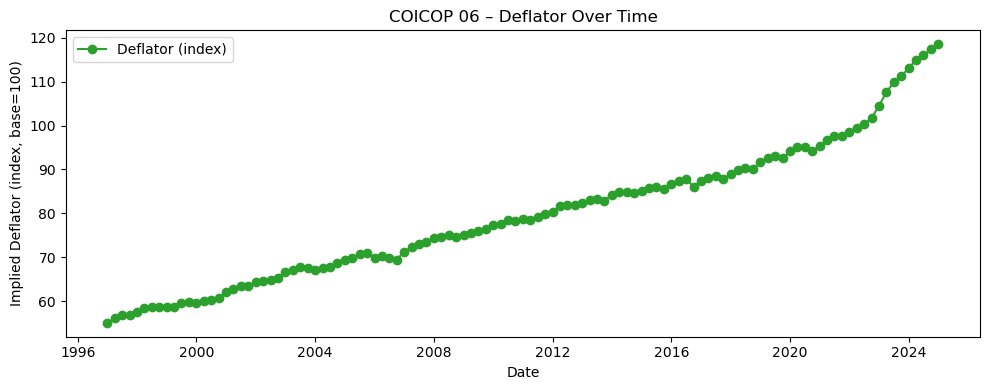

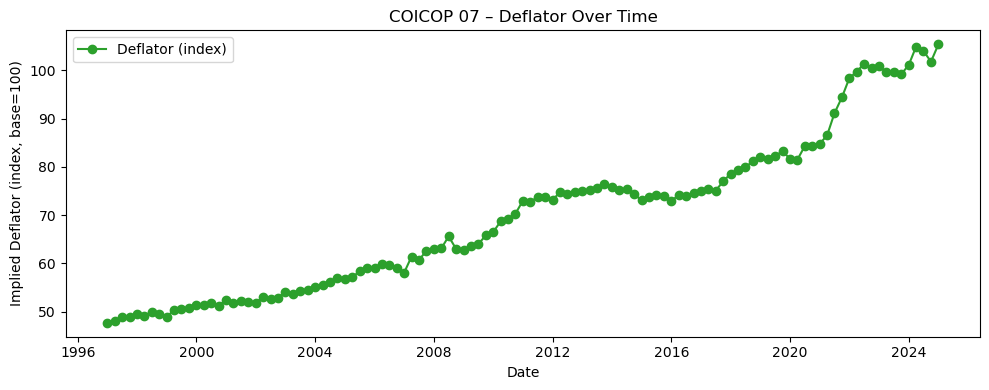

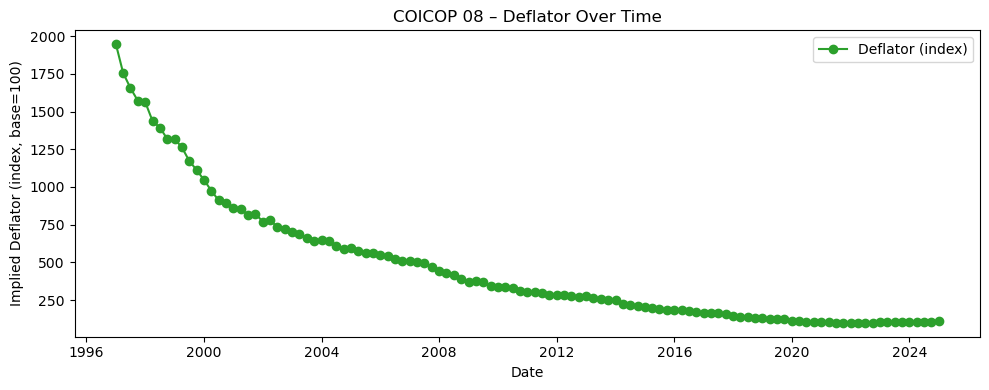

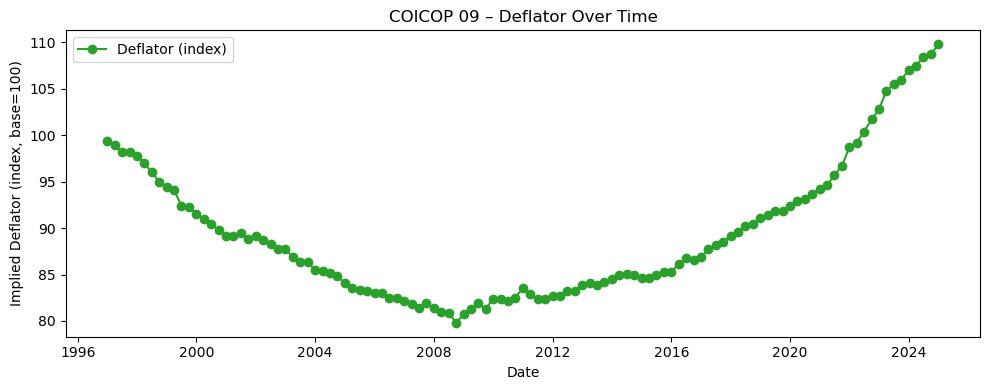

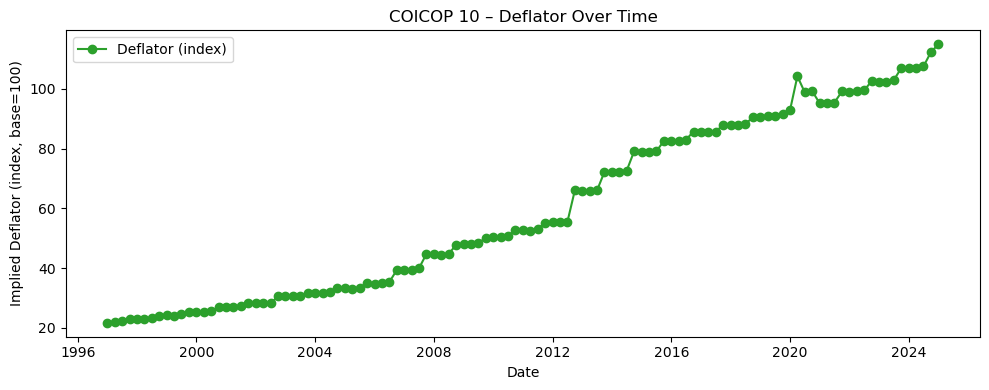

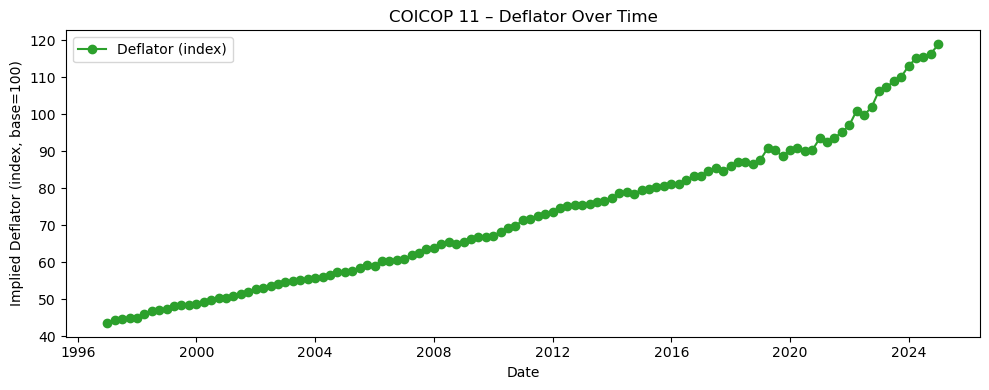

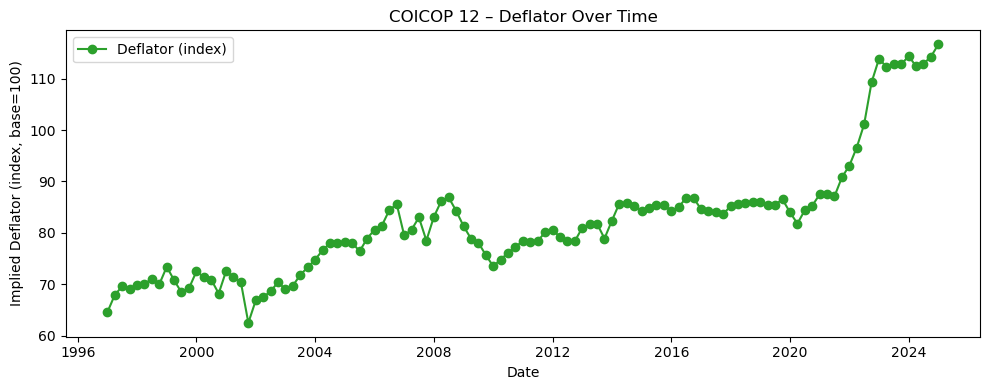

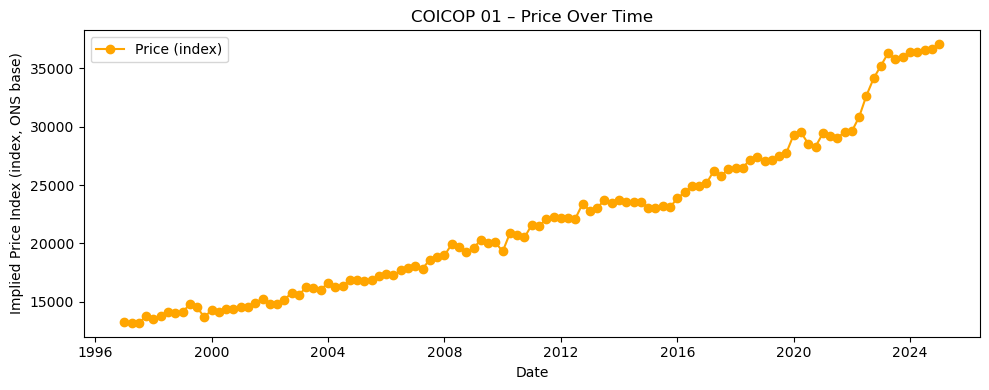

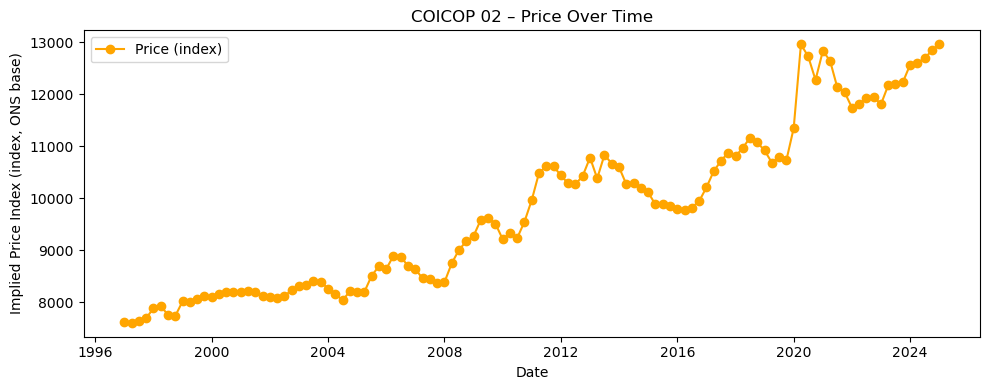

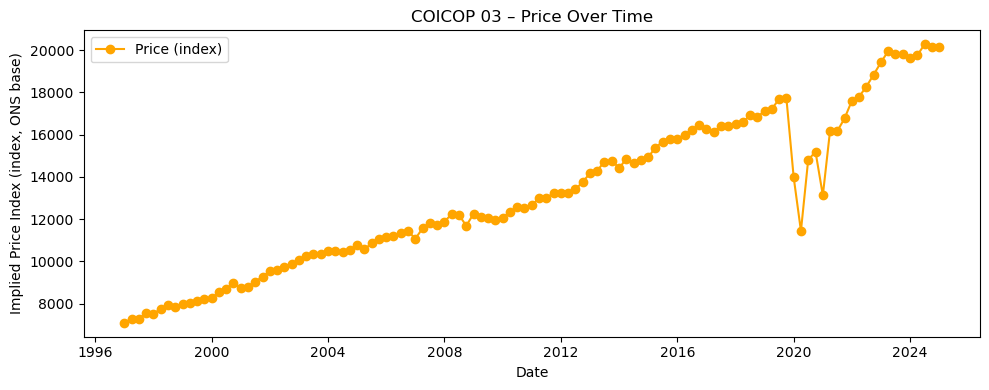

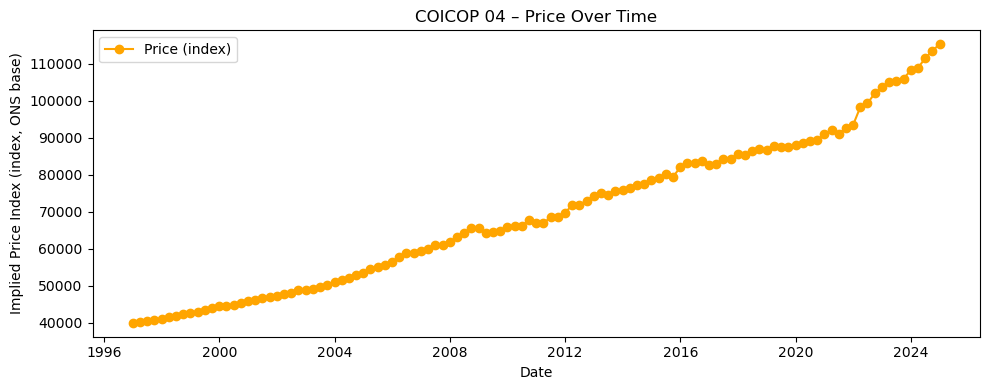

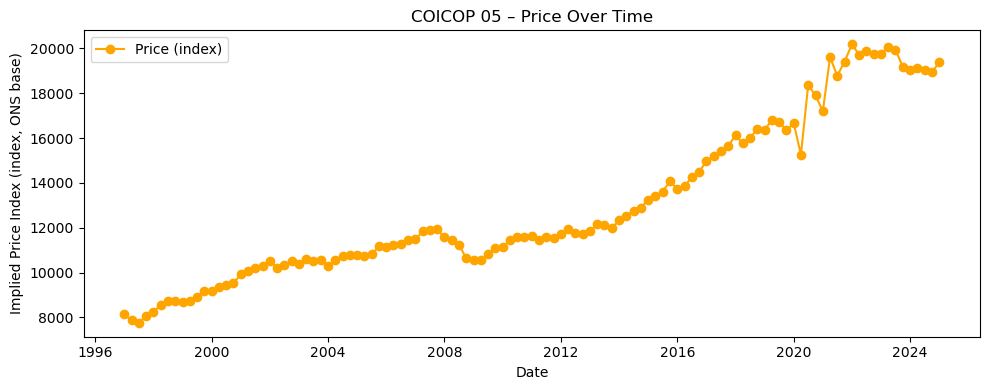

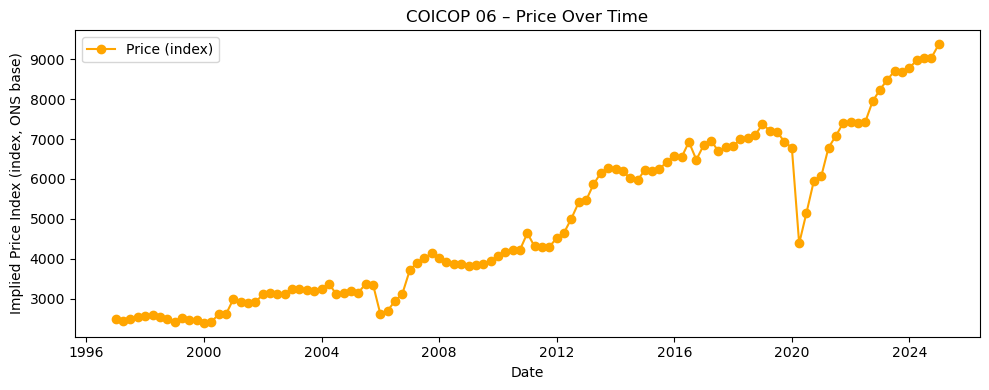

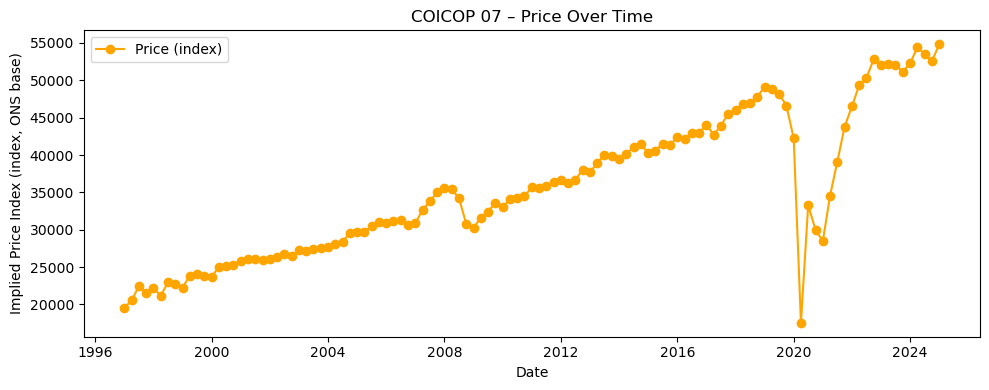

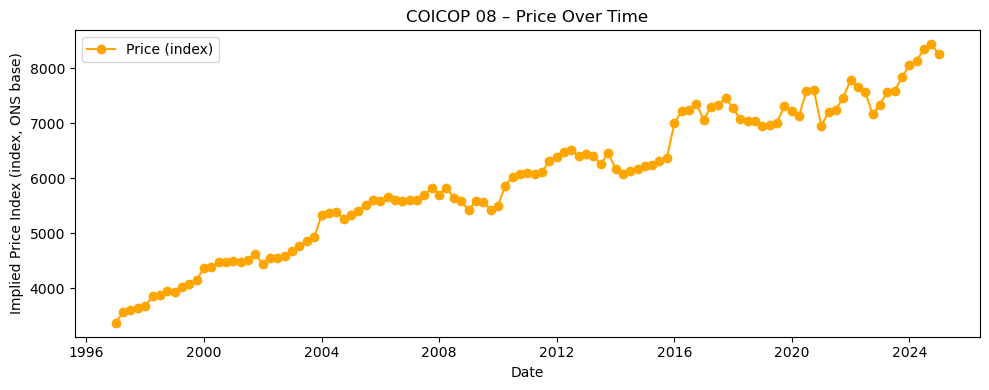

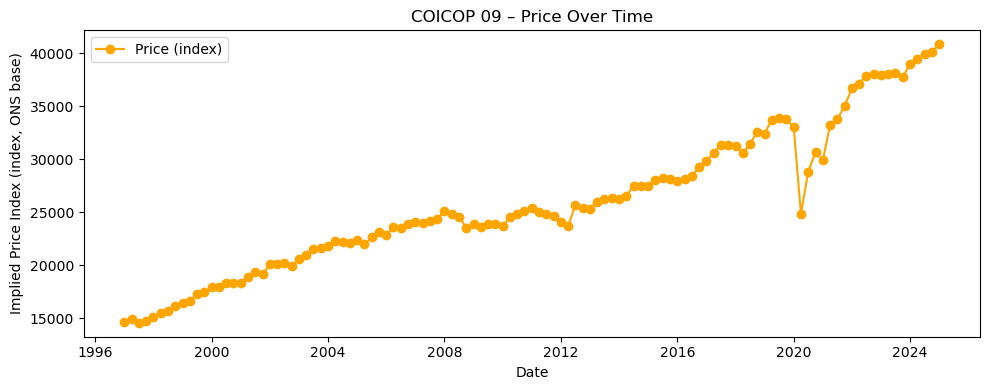

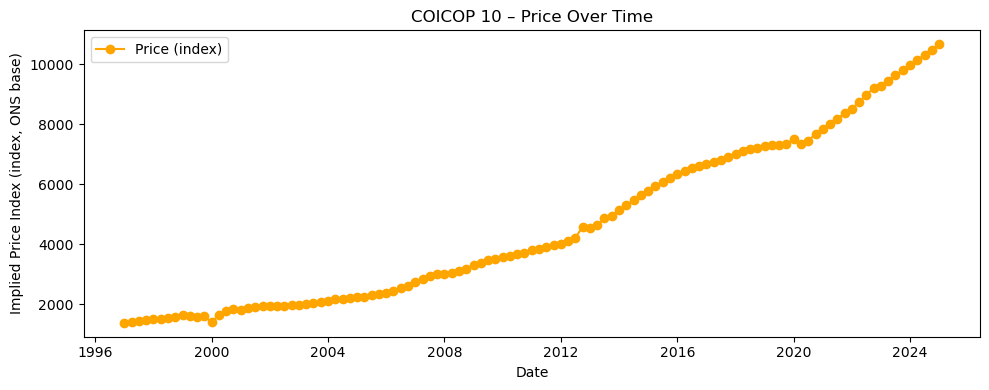

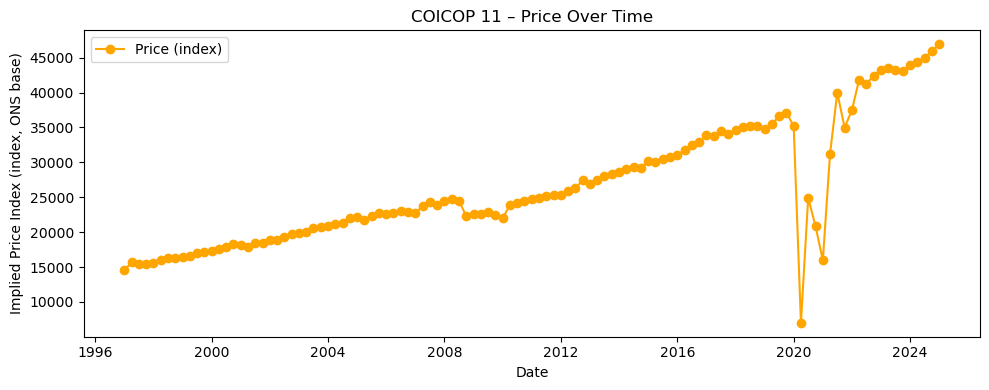

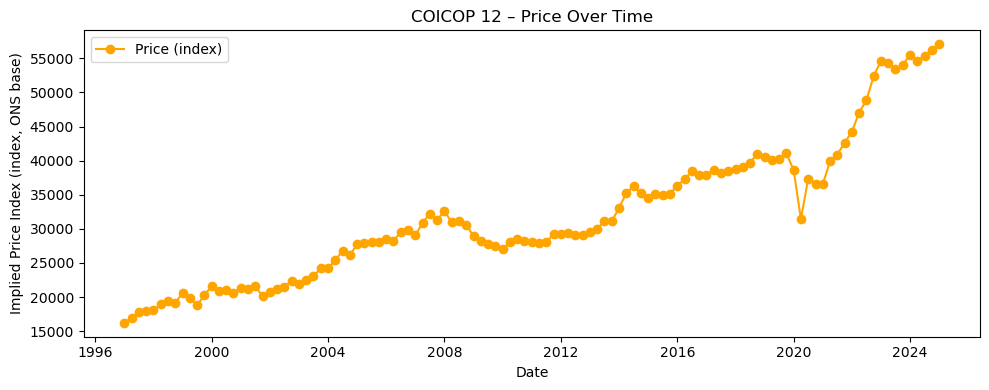

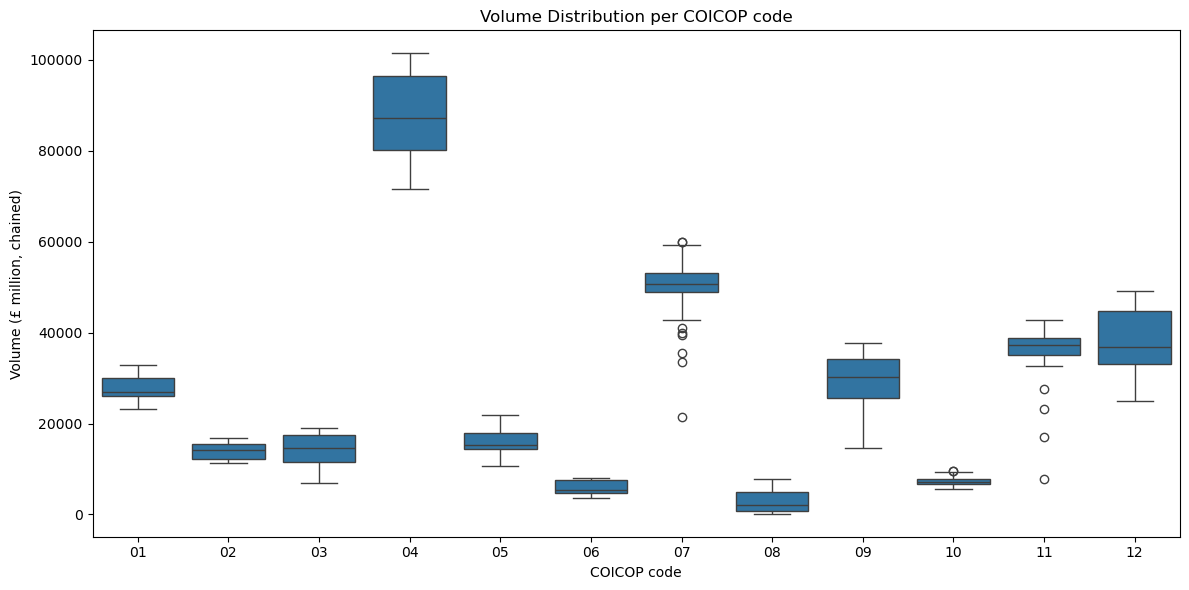

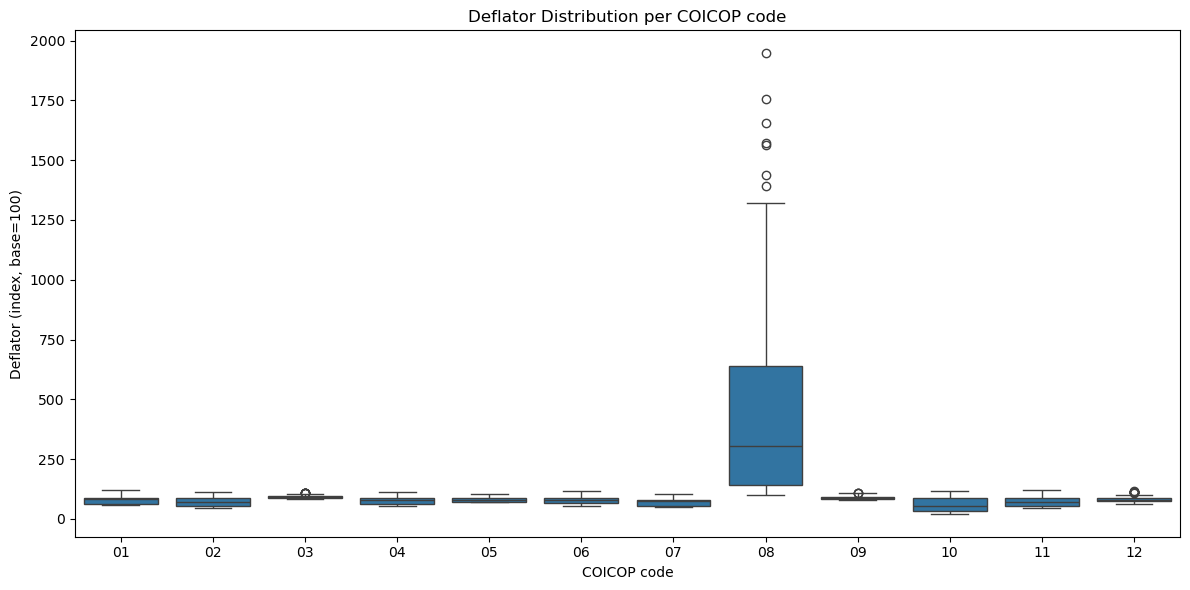

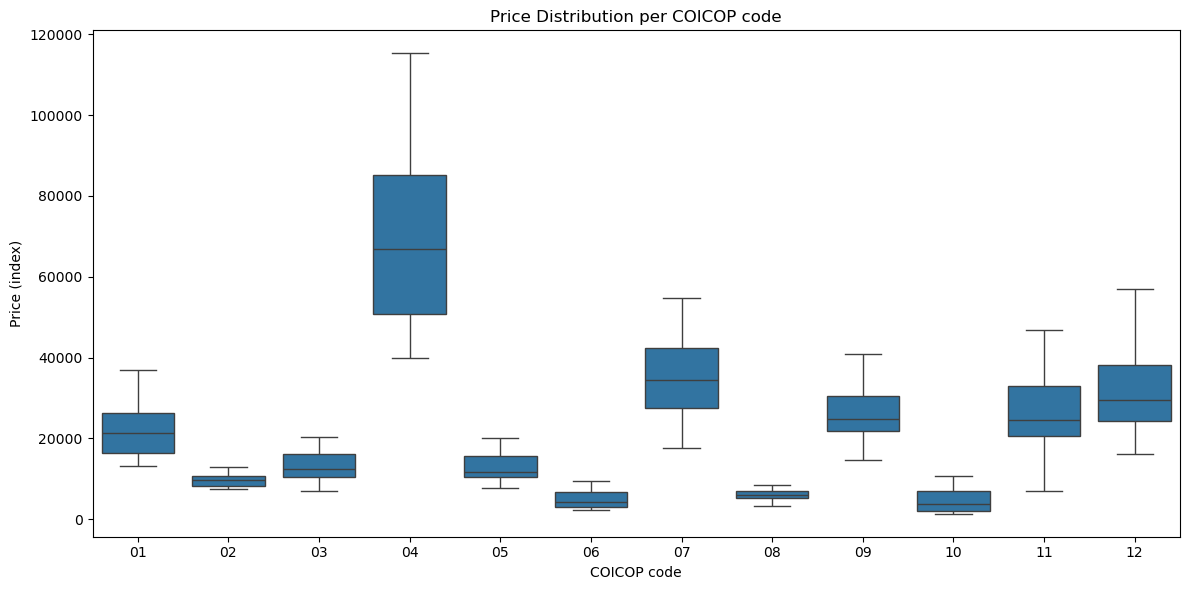

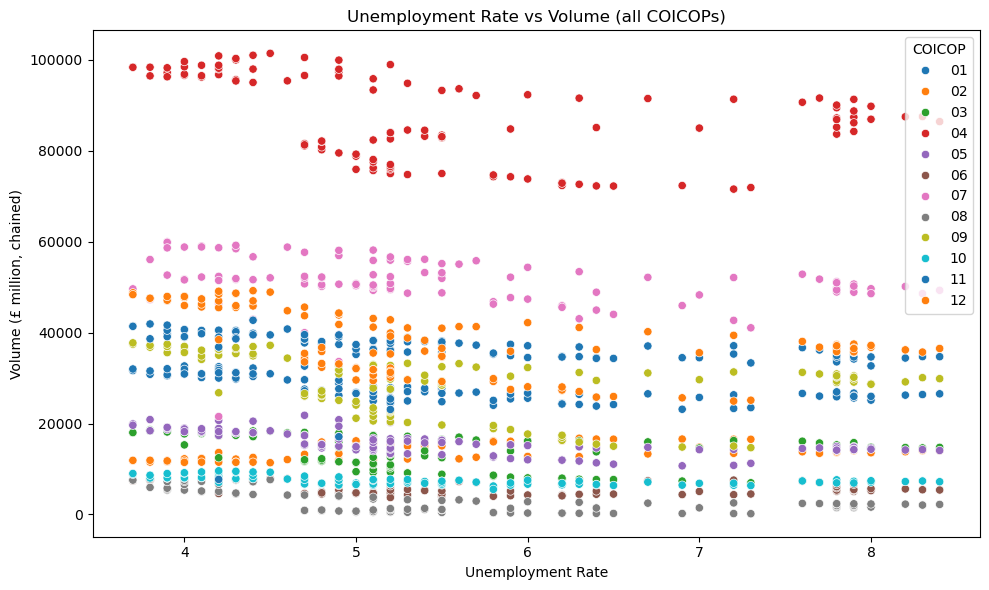

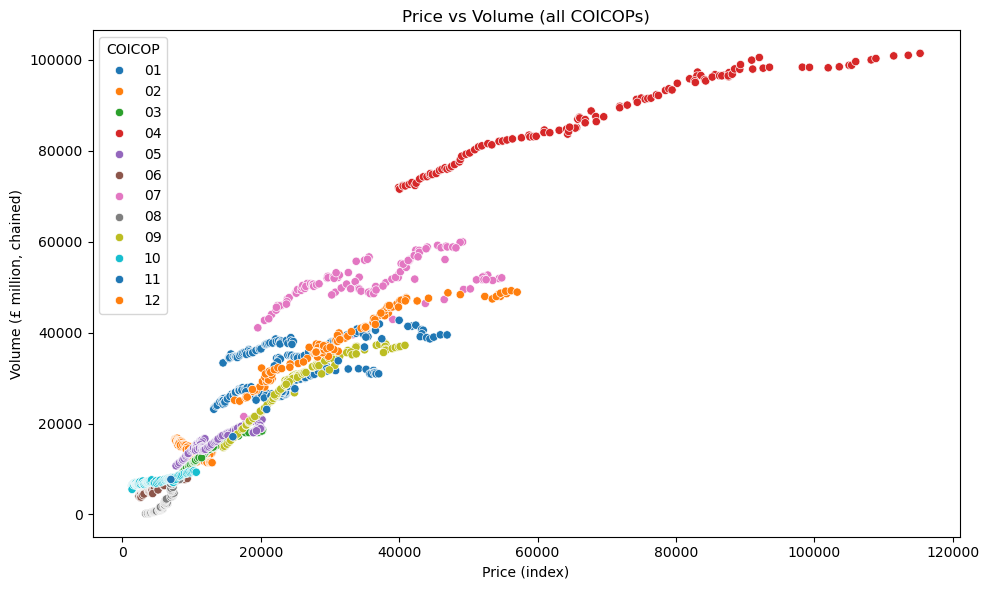

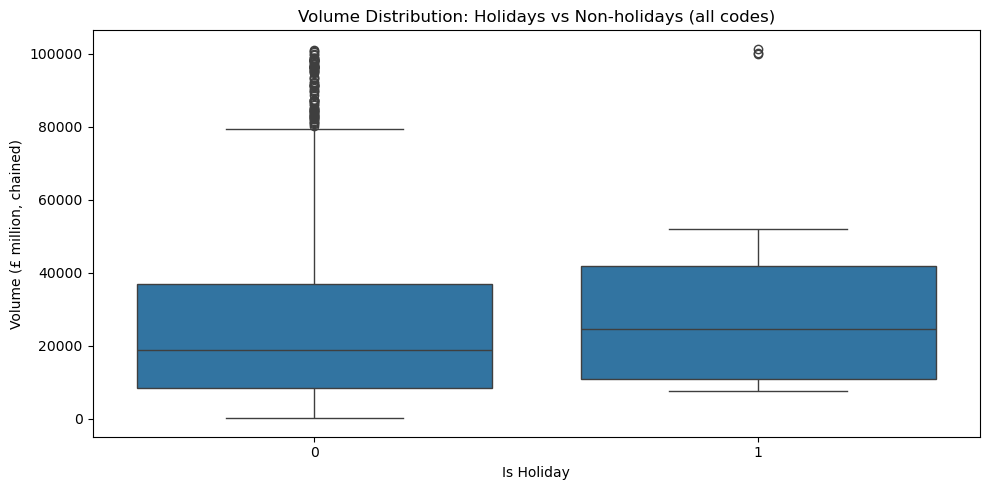

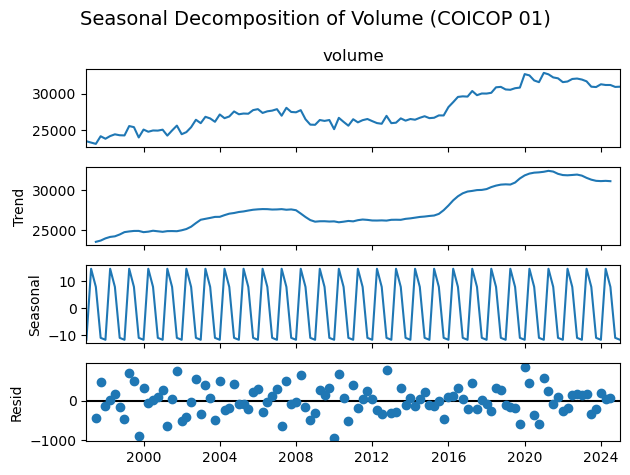

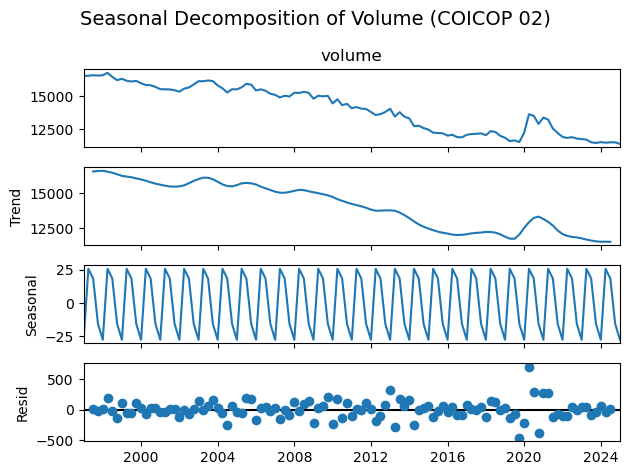

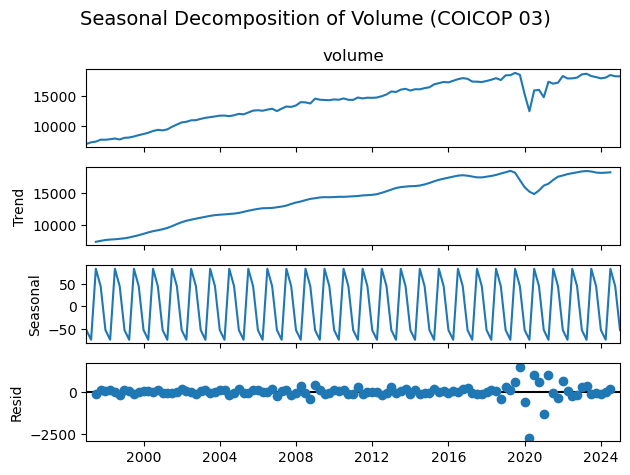

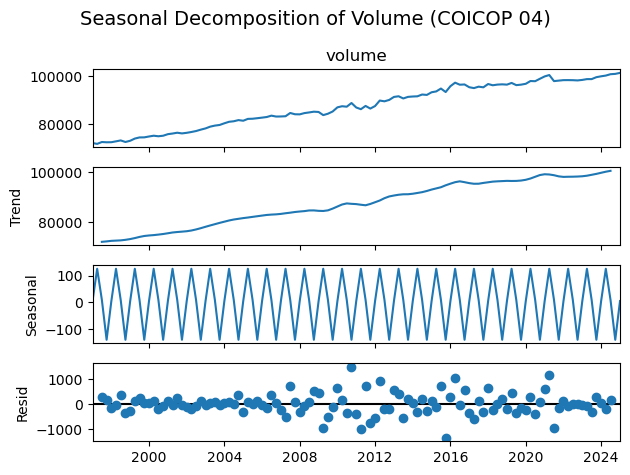

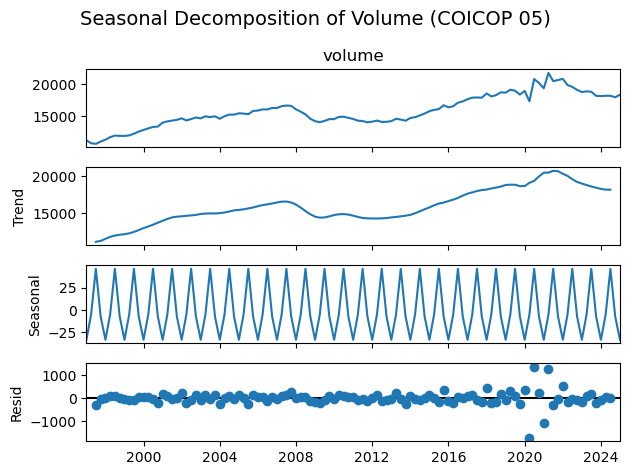

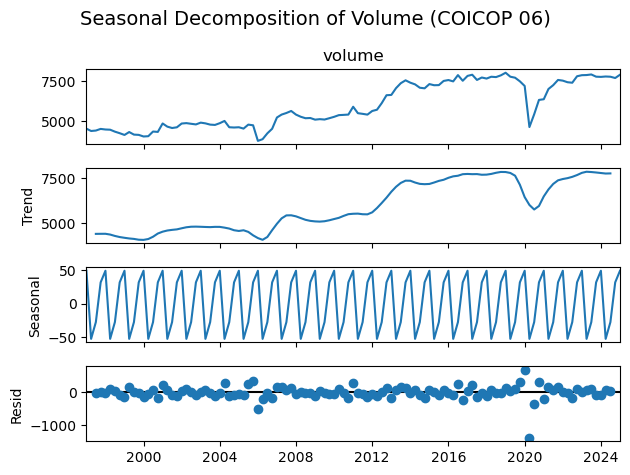

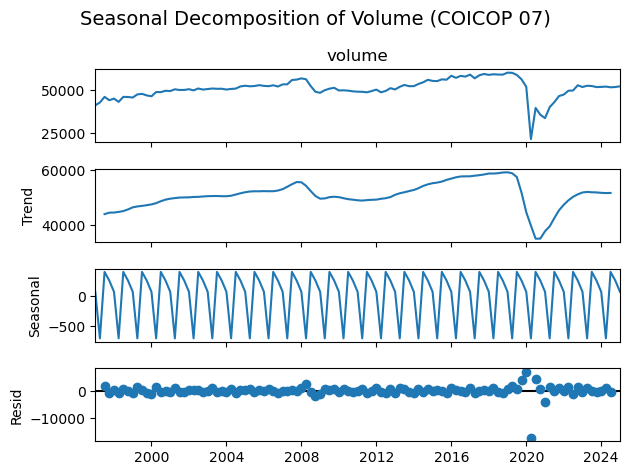

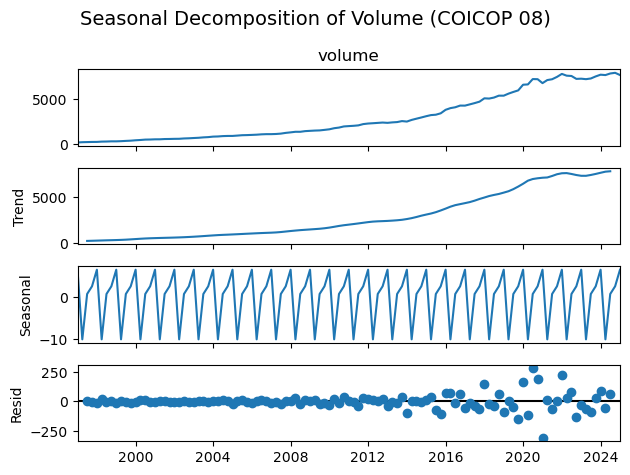

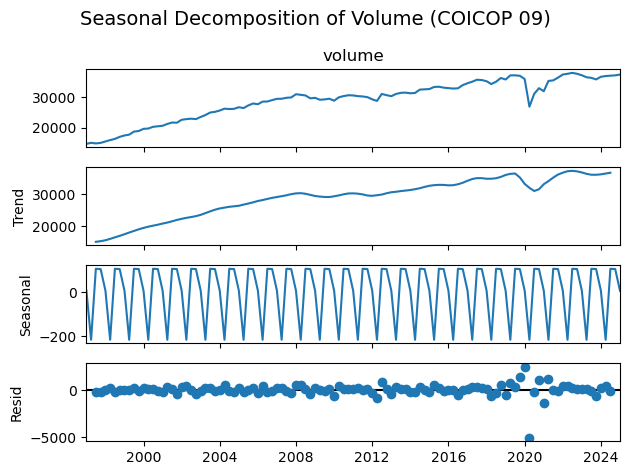

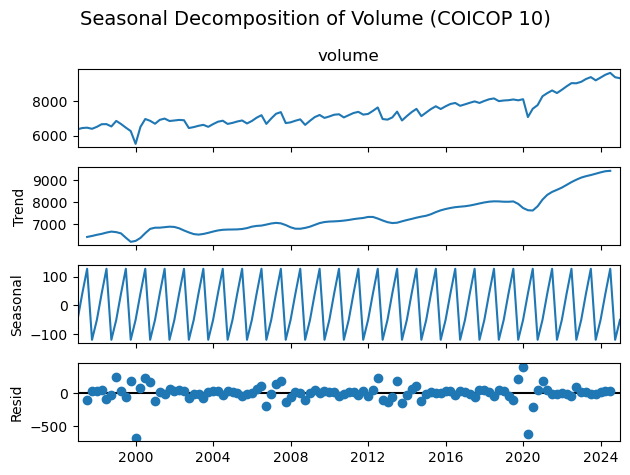

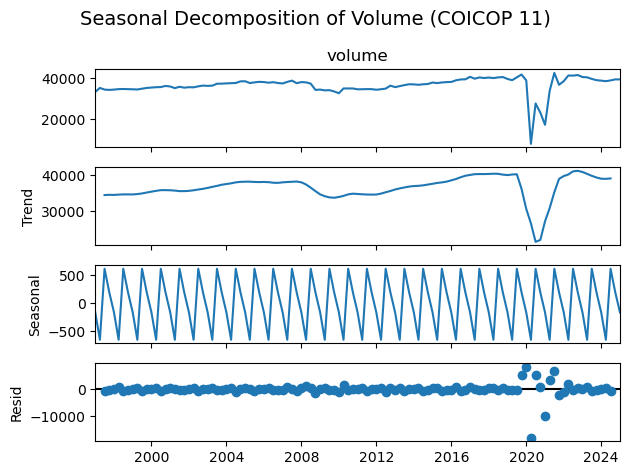

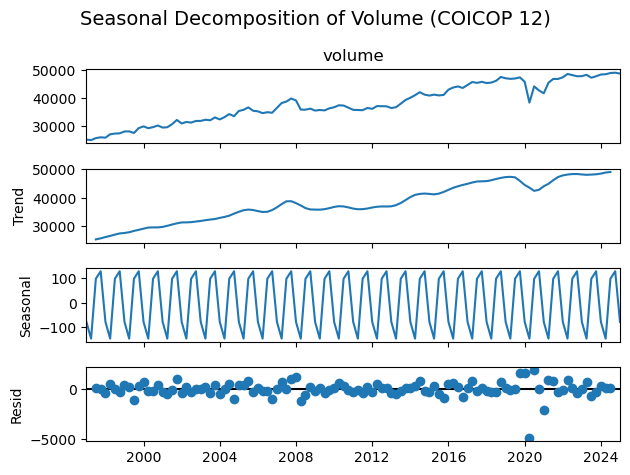

✅ EDA complete for all COICOP codes.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display

# ---- Formatting for pretty tables ----
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# ---- Load Data ----
CSV_FILE = "Cleaned_Coicop_Data.csv"
df = pd.read_csv(CSV_FILE, parse_dates=['ds'])
df['coicop_base'] = df['coicop_base'].apply(lambda x: f"{int(x):02d}")

# ---- Basic Info ----
print("Shape:", df.shape)
print("Columns:", df.columns.to_list())
print("Date range:", df['ds'].min().date(), "to", df['ds'].max().date())
print("Unique COICOP codes:", sorted(df['coicop_base'].unique()))

# ---- Nulls Table ----
nulls = df.isnull().sum().reset_index()
nulls.columns = ['Column', 'Null count']
display(nulls)

# ---- Rows per COICOP Table ----
rows_per_code = df['coicop_base'].value_counts().sort_index().rename("Rows")
rows_per_code_df = rows_per_code.reset_index().rename(columns={'index': 'COICOP'})
display(rows_per_code_df)

# ---- Descriptive Stats Table ----
desc = df.describe().T.round(2)
display(desc)

# ---- Correlation Matrix Table ----
corr = df[['volume','deflator','price','unemployment_rate','is_holiday']].corr().round(2)
display(corr)

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# ---- Volume Trends (Volume vs Time for each COICOP) ----
for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds')
    plt.figure(figsize=(10, 4))
    plt.plot(sub['ds'], sub['volume'], color='tab:blue', marker='o', label='Volume (£m, chained)')
    plt.title(f"COICOP {code} – Volume Over Time")
    plt.xlabel('Date')
    plt.ylabel('Volume (£ million, chained)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Deflator Trends (Deflator vs Time for each COICOP) ----
for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds')
    plt.figure(figsize=(10, 4))
    plt.plot(sub['ds'], sub['deflator'], color='tab:green', marker='o', label='Deflator (index)')
    plt.title(f"COICOP {code} – Deflator Over Time")
    plt.xlabel('Date')
    plt.ylabel('Implied Deflator (index, base=100)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Price Trends (Price vs Time for each COICOP) ----
for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds')
    plt.figure(figsize=(10, 4))
    plt.plot(sub['ds'], sub['price'], color='orange', marker='o', label='Price (index)')
    plt.title(f"COICOP {code} – Price Over Time")
    plt.xlabel('Date')
    plt.ylabel('Implied Price Index (index, ONS base)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Boxplots (Volume, Deflator, Price per COICOP) ----
for var, ylab, title in [
    ("volume", "Volume (£ million, chained)", "Volume Distribution"),
    ("deflator", "Deflator (index, base=100)", "Deflator Distribution"),
    ("price", "Price (index)", "Price Distribution"),
]:
    plt.figure(figsize=(12,6))
    sns.boxplot(x="coicop_base", y=var, data=df)
    plt.title(f"{title} per COICOP code")
    plt.xlabel("COICOP code")
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.show()

# ---- Unemployment and Volume Relationship ----
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="unemployment_rate", y="volume", hue="coicop_base", palette="tab10")
plt.title("Unemployment Rate vs Volume (all COICOPs)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Volume (£ million, chained)")
plt.legend(title="COICOP")
plt.tight_layout()
plt.show()

# ---- Price and Volume Relationship ----
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="price", y="volume", hue="coicop_base", palette="tab10")
plt.title("Price vs Volume (all COICOPs)")
plt.xlabel("Price (index)")
plt.ylabel("Volume (£ million, chained)")
plt.legend(title="COICOP")
plt.tight_layout()
plt.show()

# ---- Impact of Holidays ----
plt.figure(figsize=(10,5))
sns.boxplot(x="is_holiday", y="volume", data=df)
plt.title("Volume Distribution: Holidays vs Non-holidays (all codes)")
plt.xlabel("Is Holiday")
plt.ylabel("Volume (£ million, chained)")
plt.tight_layout()
plt.show()

# ---- Seasonal Decomposition for Each COICOP ----
for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds')
    if sub.shape[0] >= 8:
        try:
            result = seasonal_decompose(sub.set_index('ds')['volume'], model='additive', period=4)
            result.plot()
            plt.suptitle(f"Seasonal Decomposition of Volume (COICOP {code})", fontsize=14)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Skipping COICOP {code} due to error: {e}")

print("✅ EDA complete for all COICOP codes.")


## 4. Model Development

### 4.1 Prophet Model

23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing


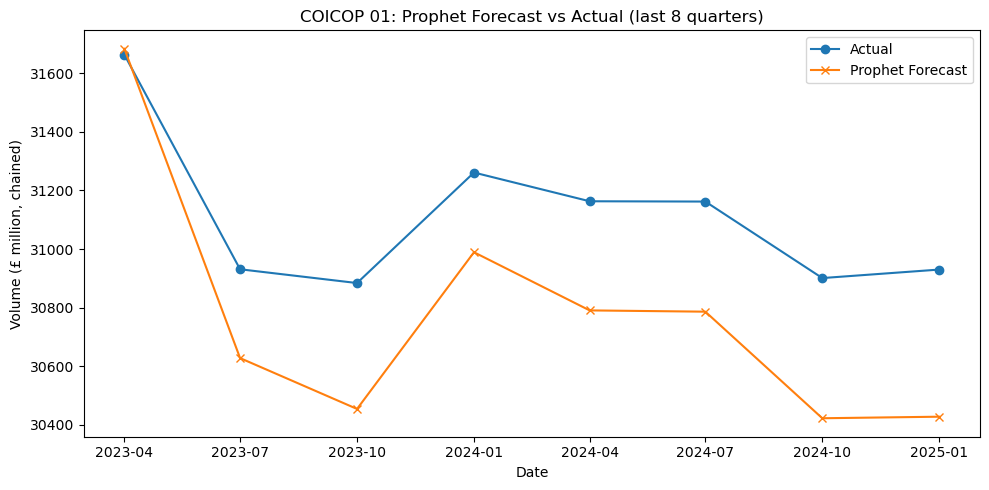

23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing


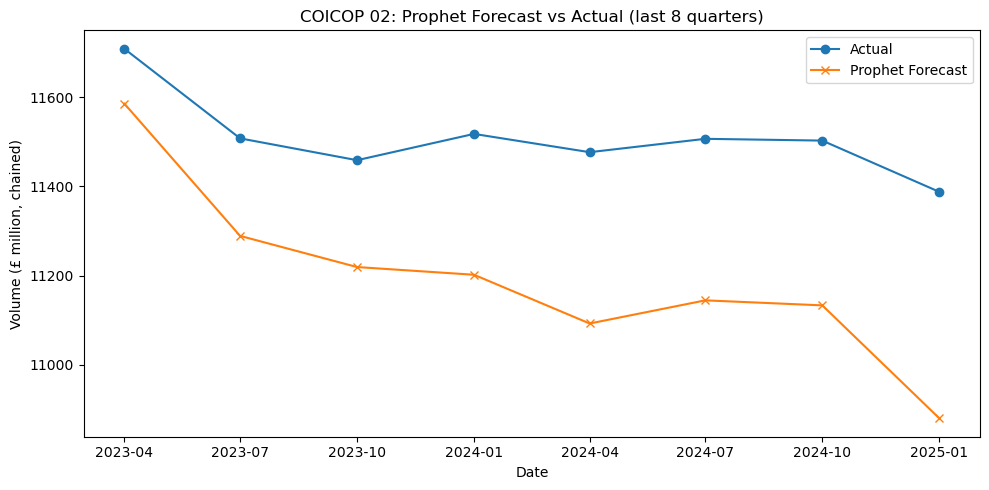

23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing


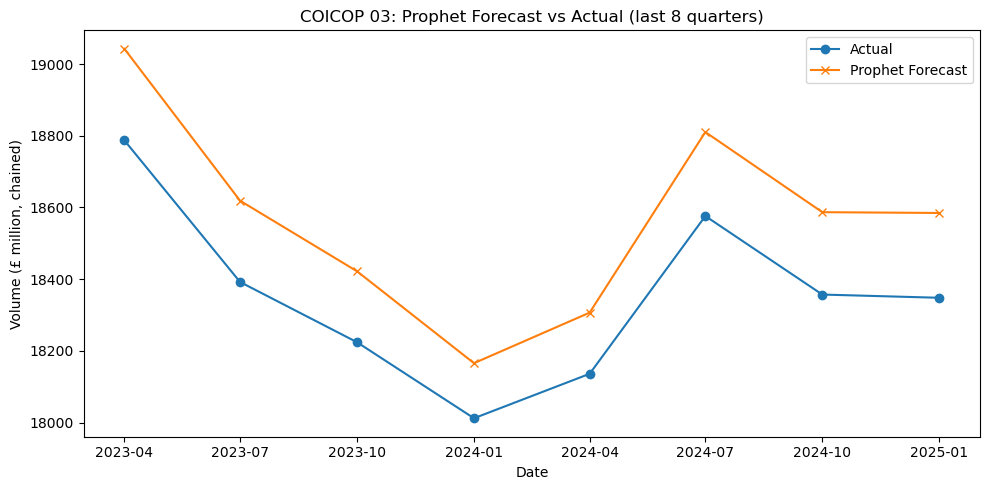

23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing


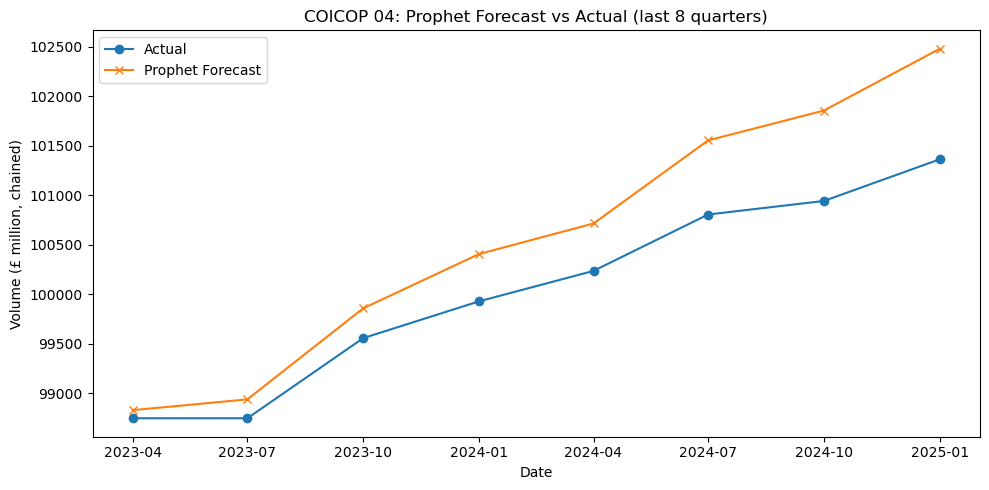

23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing


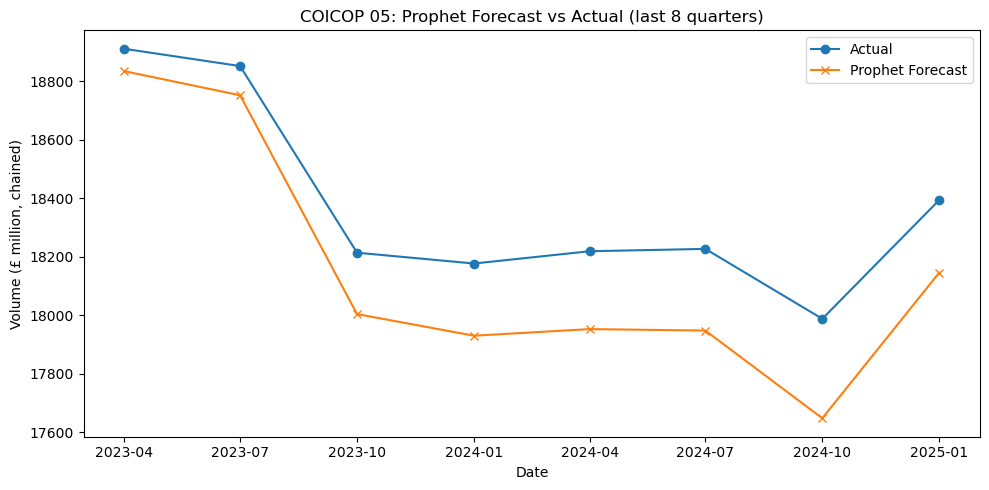

23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing


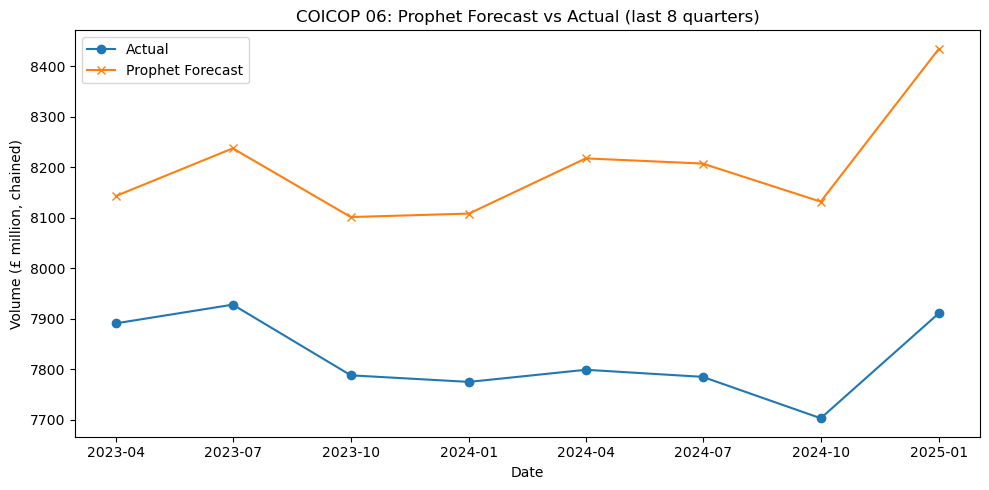

23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing


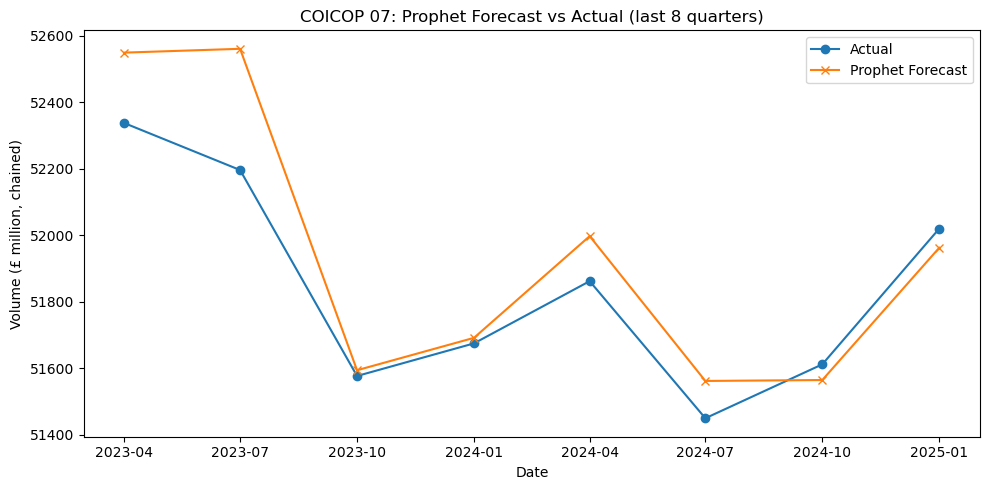

23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing


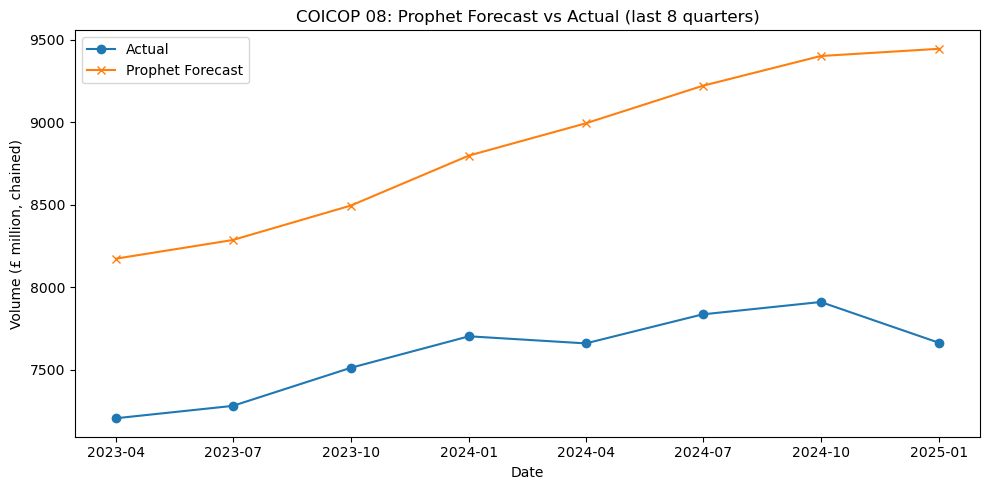

23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing


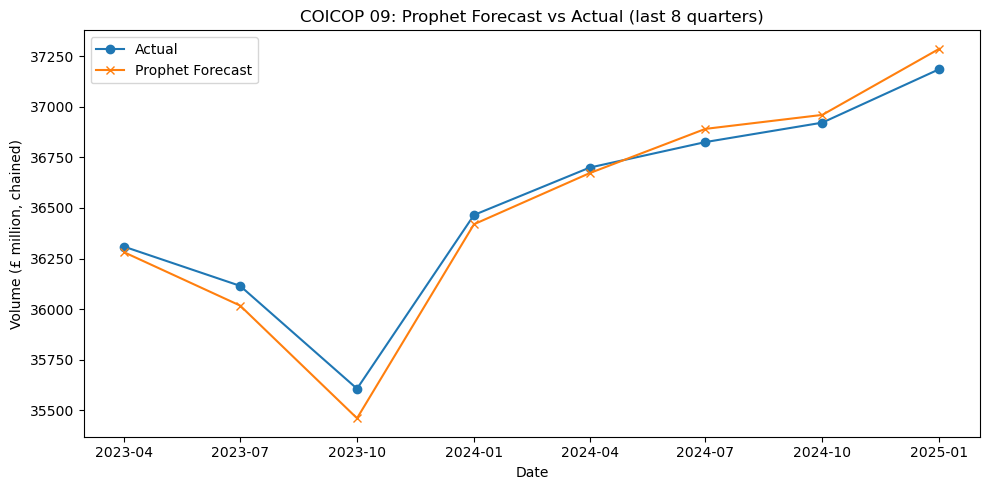

23:15:16 - cmdstanpy - INFO - Chain [1] start processing
23:15:16 - cmdstanpy - INFO - Chain [1] done processing


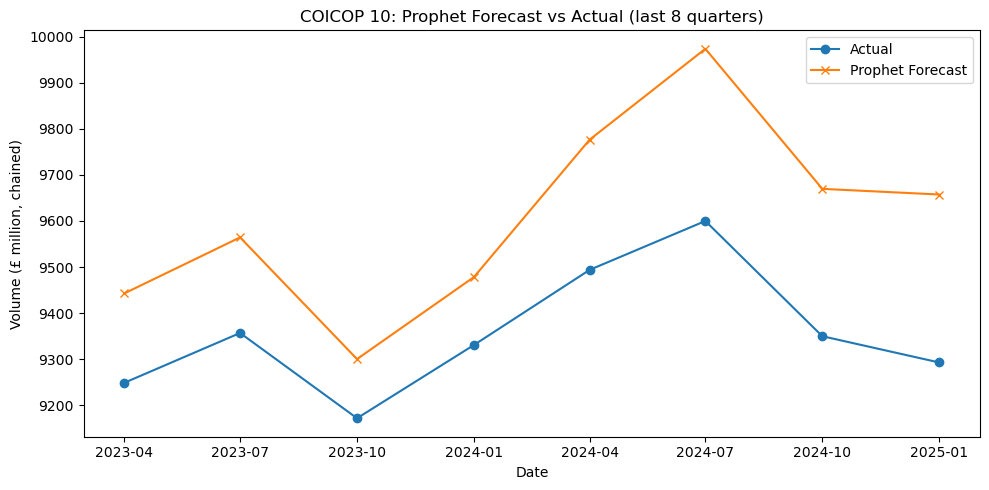

23:15:16 - cmdstanpy - INFO - Chain [1] start processing
23:15:16 - cmdstanpy - INFO - Chain [1] done processing


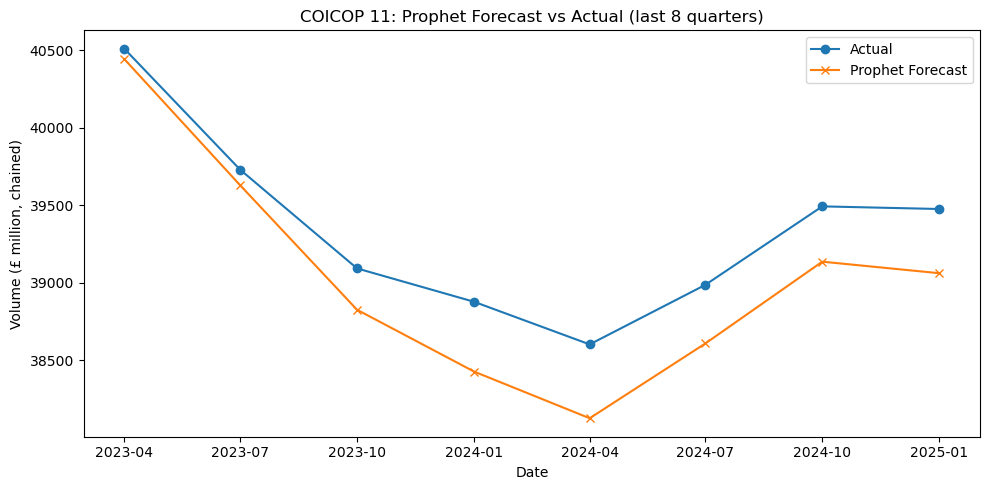

23:15:16 - cmdstanpy - INFO - Chain [1] start processing
23:15:16 - cmdstanpy - INFO - Chain [1] done processing


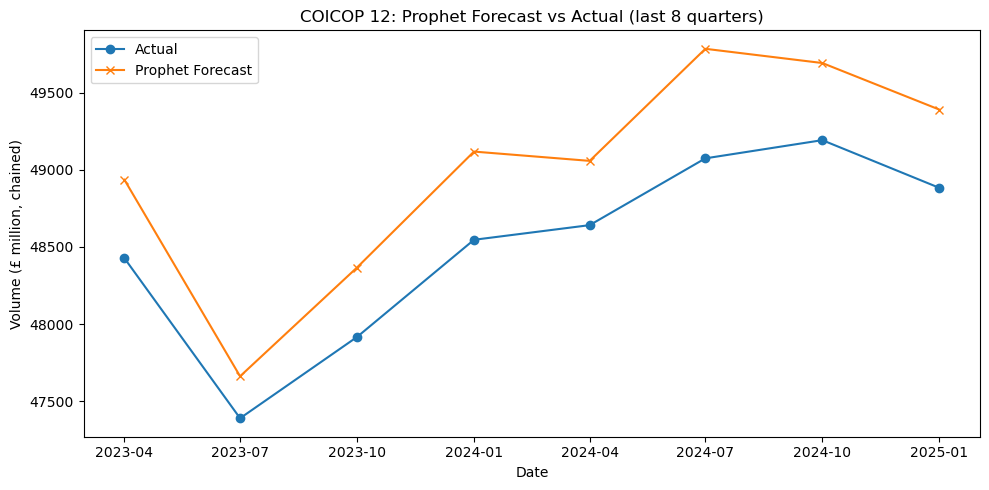


Prophet Model Performance by COICOP (copy-paste ready):

COICOP      MAE     RMSE  MAPE
    01   344.10   372.68  1.11
    02   315.34   334.40  2.75
    03   213.09   215.66  1.16
    04   539.11   636.23  0.54
    05   220.79   236.28  1.21
    06   375.31   384.21  4.80
    07   120.28   163.80  0.23
    08 1,256.09 1,285.65 16.48
    09    68.53    79.23  0.19
    10   252.19   267.70  2.69
    11   313.57   345.74  0.80
    12   492.14   505.96  1.01
✅ Prophet modeling complete. Models saved in the same directory as the notebook!


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pickle
import os

# Load data
CSV_FILE = "Cleaned_Coicop_Data.csv"
df = pd.read_csv(CSV_FILE, parse_dates=['ds'])
df['coicop_base'] = df['coicop_base'].apply(lambda x: f"{int(x):02d}")

# To store forecast results
prophet_results = []

# Parameters
test_periods = 8  # number of quarters for test set

# Creates output directory for models if not exists (optional)
MODEL_DIR = "./Saved_Models"
# os.makedirs(MODEL_DIR, exist_ok=True)  # Can use this if we want to ensure dir exists

for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds').reset_index(drop=True)
    if sub.shape[0] <= test_periods + 4:
        print(f"Skipping COICOP {code}: not enough data.")
        continue
    
    prophet_df = sub.rename(columns={'volume': 'y'})[['ds', 'y', 'price', 'deflator', 'unemployment_rate', 'is_holiday']].copy()
    train = prophet_df.iloc[:-test_periods]
    test  = prophet_df.iloc[-test_periods:]

    m = Prophet()
    #Adding external regressors, so forecast depends not only on trends and seasonality, but also these variables.
    for reg in ['price', 'deflator', 'unemployment_rate', 'is_holiday']:
        m.add_regressor(reg)
    
    m.fit(train)

    # SAVE MODEL
    model_filename = f"prophet_model_coicop_{code}.pkl"
    with open(os.path.join(MODEL_DIR, model_filename), "wb") as f:
        pickle.dump(m, f)

    # Forecast
    future = test.copy()
    forecast = m.predict(future)

    y_true = test['y'].values
    y_pred = forecast['yhat'].values

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    prophet_results.append({
        'COICOP': code,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'y_true': y_true,
        'y_pred': y_pred,
        'test_dates': test['ds'].values
    })

    # Plot actual vs predicted
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(test['ds'], y_true, marker='o', label='Actual')
    plt.plot(test['ds'], y_pred, marker='x', label='Prophet Forecast')
    plt.title(f"COICOP {code}: Prophet Forecast vs Actual (last {test_periods} quarters)")
    plt.xlabel("Date")
    plt.ylabel("Volume (£ million, chained)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Results table
results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k not in ['y_true', 'y_pred', 'test_dates']}
    for d in prophet_results
]).sort_values("COICOP")

summary_table = results_df[['COICOP', 'MAE', 'RMSE', 'MAPE']].round(2)
print("\nProphet Model Performance by COICOP (copy-paste ready):\n")
print(summary_table.to_string(index=False))

print("✅ Prophet modeling complete. Models saved in the same directory as the notebook!")


### 4.2 ARIMA Model

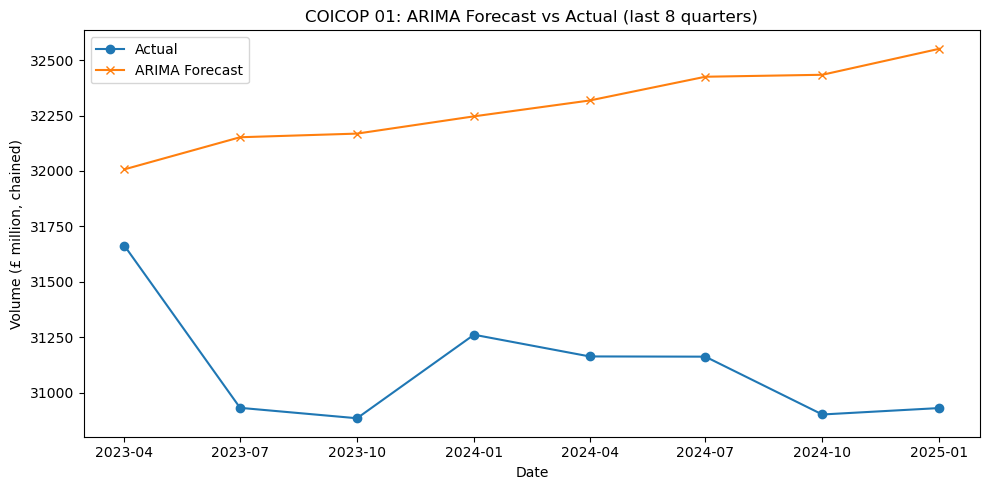

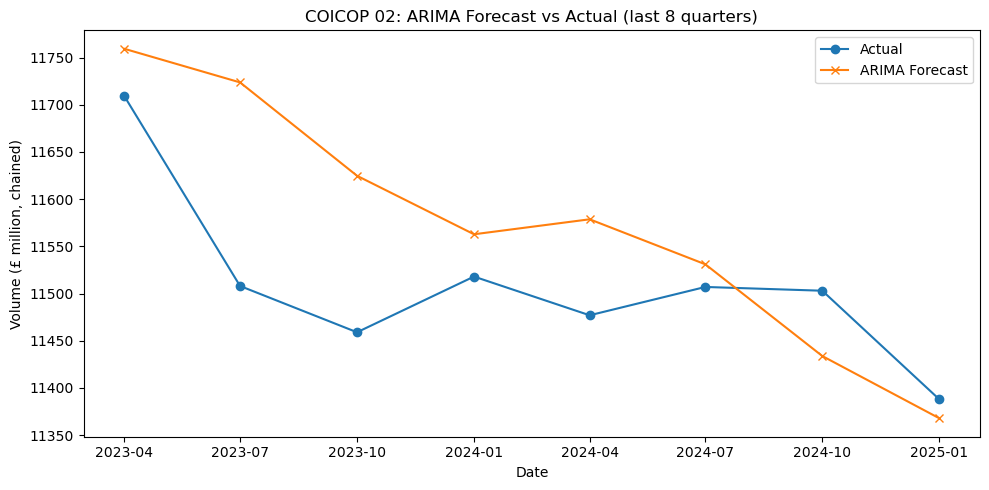

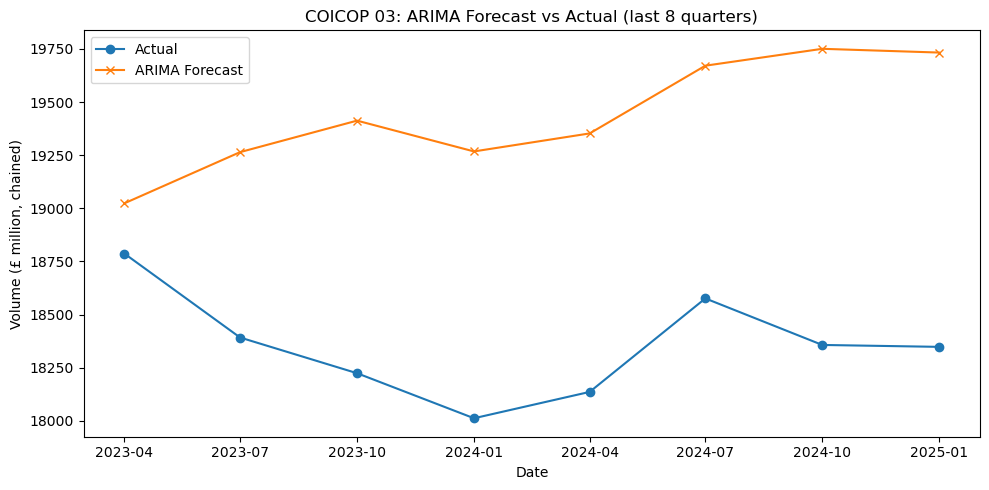

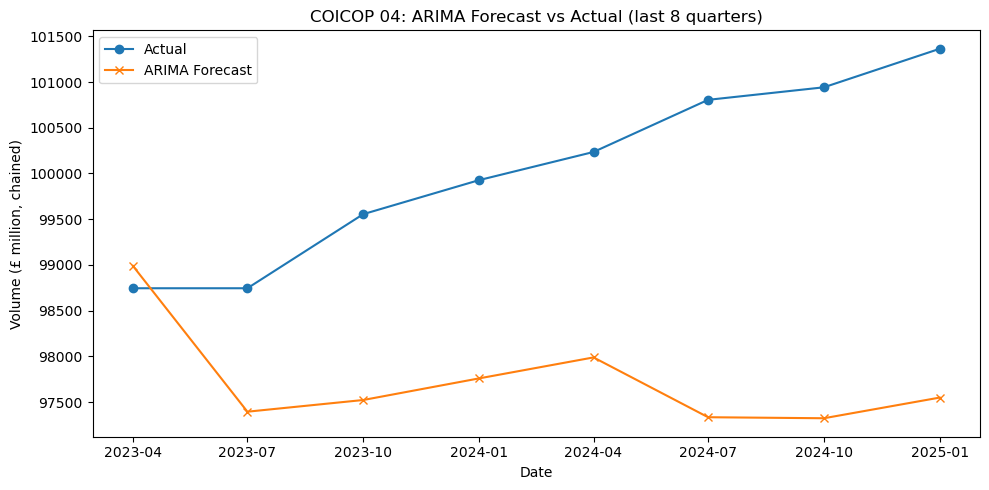

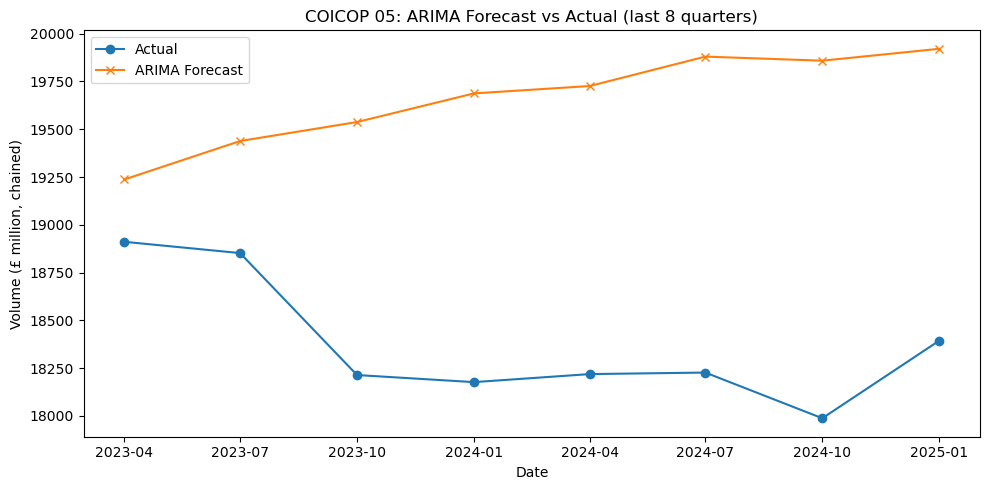

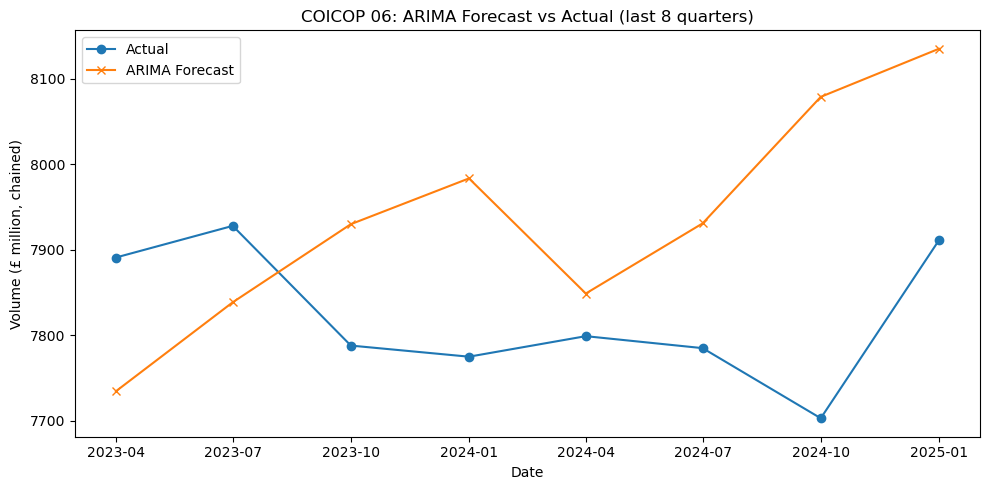

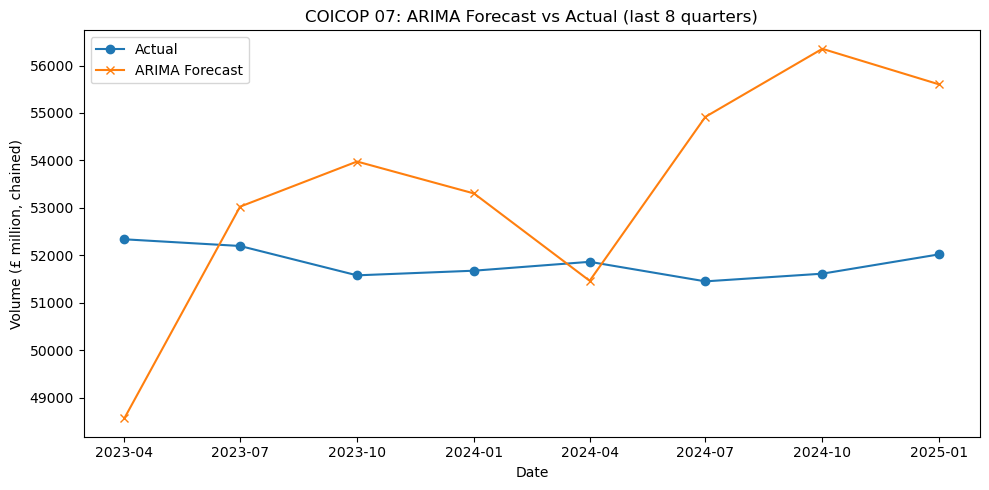

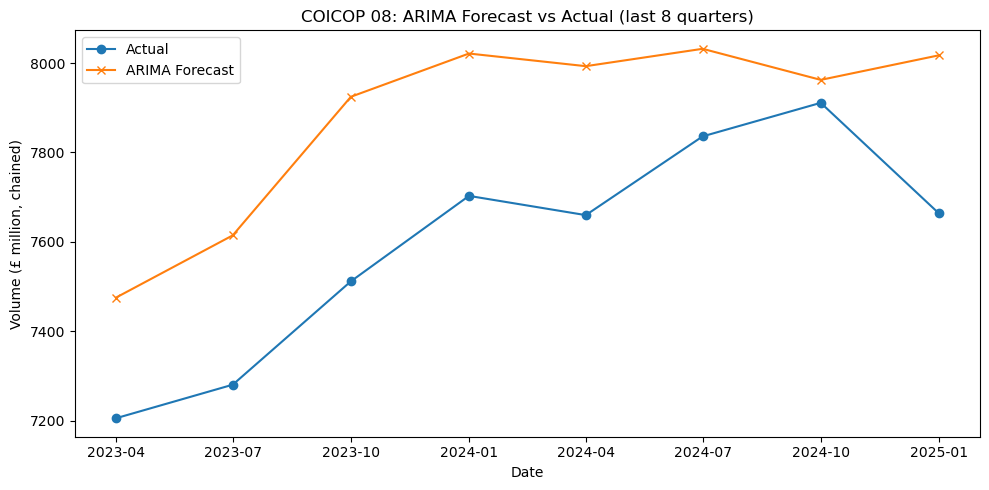

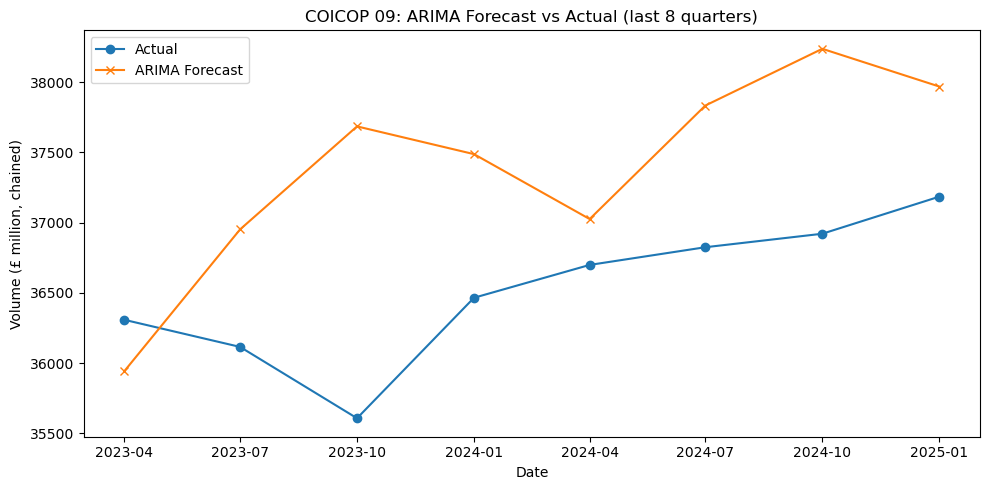

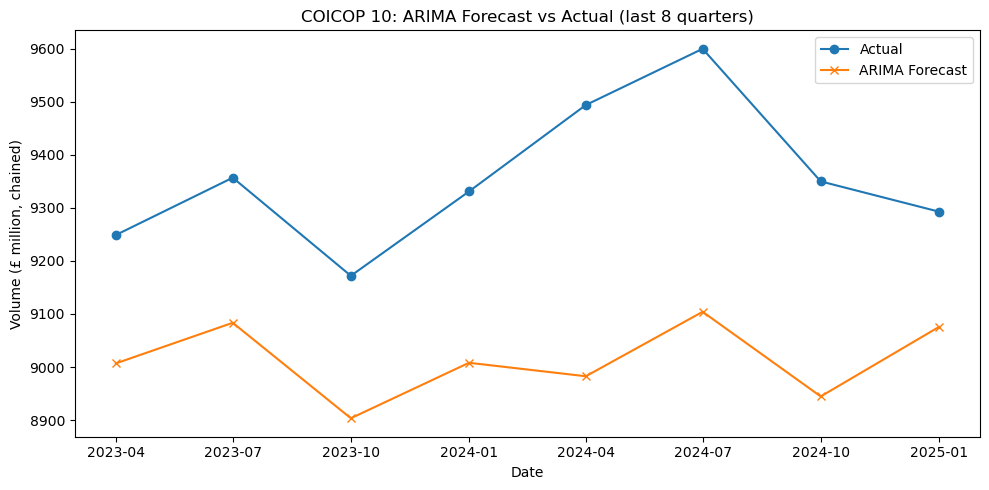

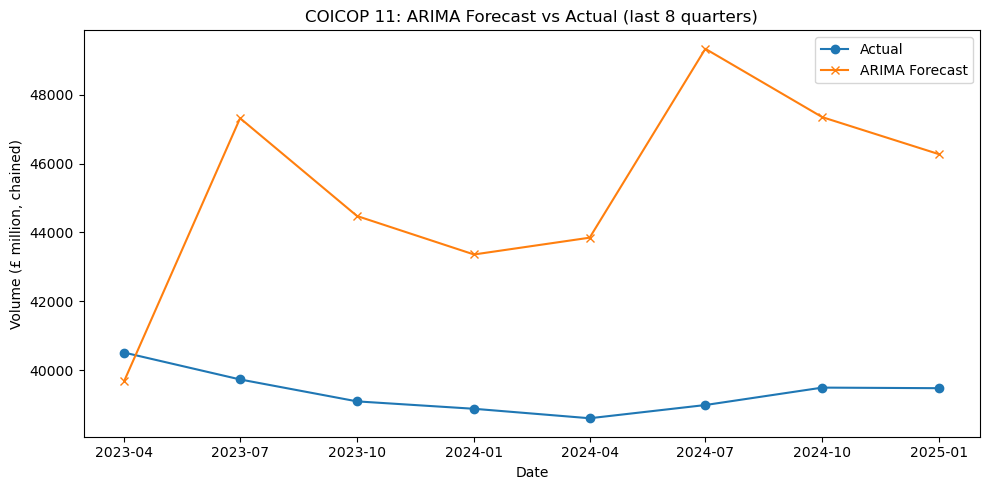

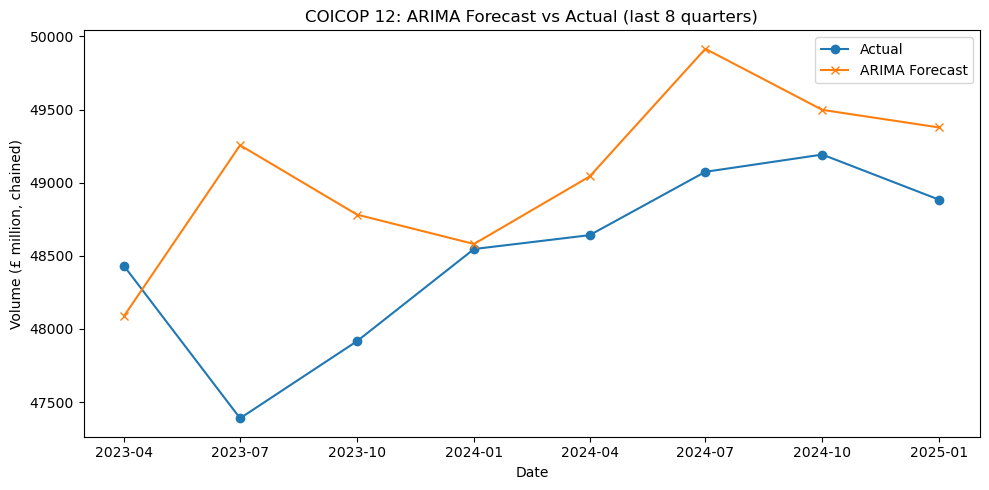


ARIMA Model Performance by COICOP (copy-paste ready):

COICOP      MAE     RMSE  MAPE
    01 1,176.22 1,232.06  3.79
    02    86.41   108.75  0.75
    03 1,080.58 1,137.36  5.91
    04 2,367.83 2,632.33  2.36
    05 1,287.89 1,383.60  7.06
    06   174.01   197.29  2.23
    07 2,602.74 2,975.56  5.02
    08   283.41   302.51  3.76
    09   967.59 1,099.74  2.66
    10   342.18   358.64  3.64
    11 6,063.09 6,611.64 15.45
    12   643.06   833.23  1.34


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

CSV_FILE = "Cleaned_Coicop_Data.csv"

df = pd.read_csv(CSV_FILE, parse_dates=['ds'])
# Ensuring coicop_base is formatted like 01, 02 etc.
df['coicop_base'] = df['coicop_base'].apply(lambda x: f"{int(x):02d}")

arima_results = []
test_periods = 8  # quarters for test set

for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds').reset_index(drop=True)
    if sub.shape[0] <= test_periods + 4:
        print(f"Skipping COICOP {code}: not enough data.")
        continue
    y = sub['volume'].values # Setting Volume  as target variable(y)
    train, test = y[:-test_periods], y[-test_periods:]
    dates_test = sub['ds'].iloc[-test_periods:]

    try:
        model = sm.tsa.statespace.SARIMAX(
            train, order=(1,1,1), seasonal_order=(1,1,1,4), 
            enforce_stationarity=False, enforce_invertibility=False)#Seasonal ARIMA with quarterly seasonality(s=4)
        results = model.fit(disp=False)

        pred = results.get_forecast(steps=test_periods)
        y_pred = pred.predicted_mean

        mae = mean_absolute_error(test, y_pred)
        mse = mean_squared_error(test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((test - y_pred) / test)) * 100

        arima_results.append({
            'COICOP': code,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'y_true': test,
            'y_pred': y_pred,
            'test_dates': dates_test
        })

        plt.figure(figsize=(10,5))
        plt.plot(dates_test, test, marker='o', label='Actual')
        plt.plot(dates_test, y_pred, marker='x', label='ARIMA Forecast')
        plt.title(f"COICOP {code}: ARIMA Forecast vs Actual (last {test_periods} quarters)")
        plt.xlabel("Date")
        plt.ylabel("Volume (£ million, chained)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"ARIMA failed for COICOP {code}: {e}")

results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k not in ['y_true', 'y_pred', 'test_dates']}
    for d in arima_results
]).sort_values("COICOP")

summary_table = results_df[['COICOP', 'MAE', 'RMSE', 'MAPE']].round(2)
print("\nARIMA Model Performance by COICOP (copy-paste ready):\n")
print(summary_table.to_string(index=False))


### 4.3 LSTM Model 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


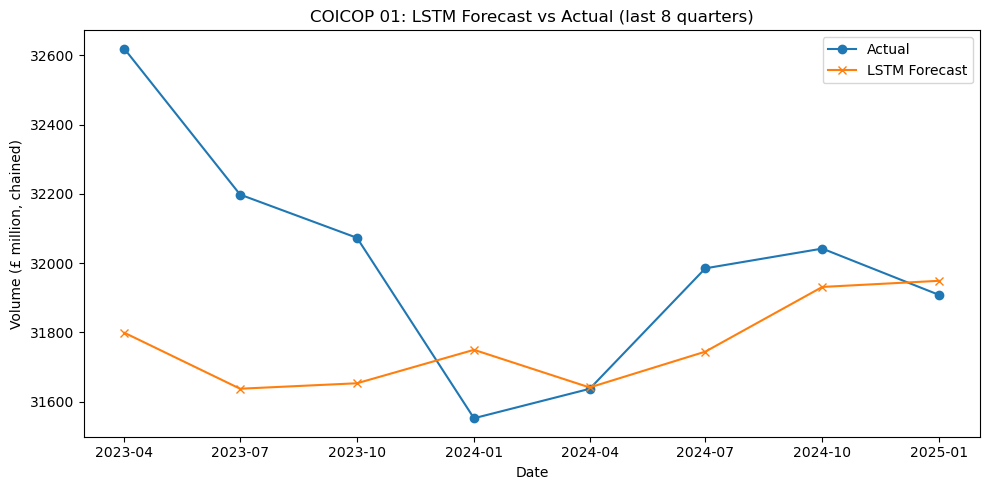

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


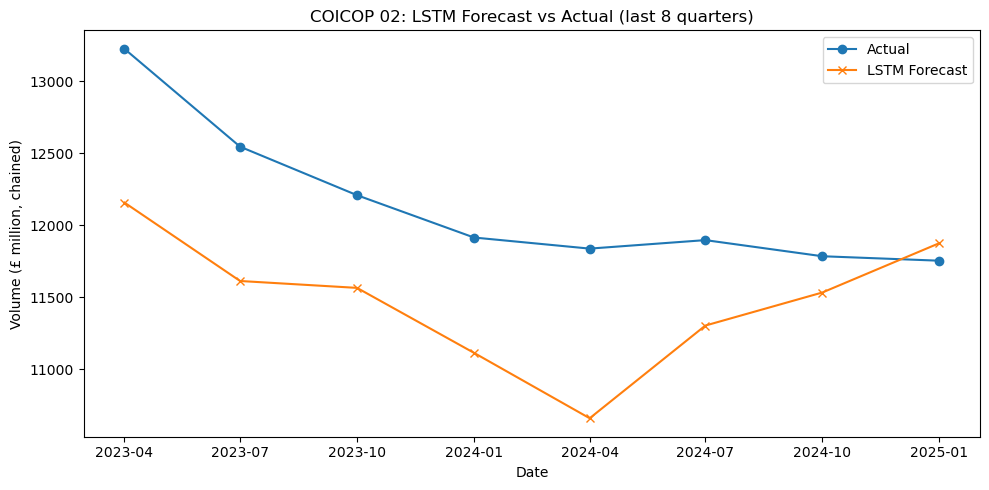

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


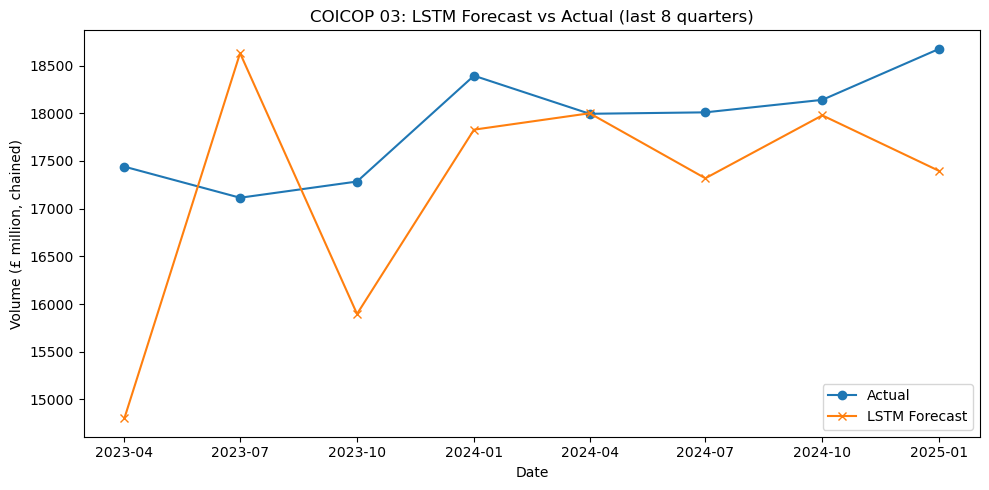

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


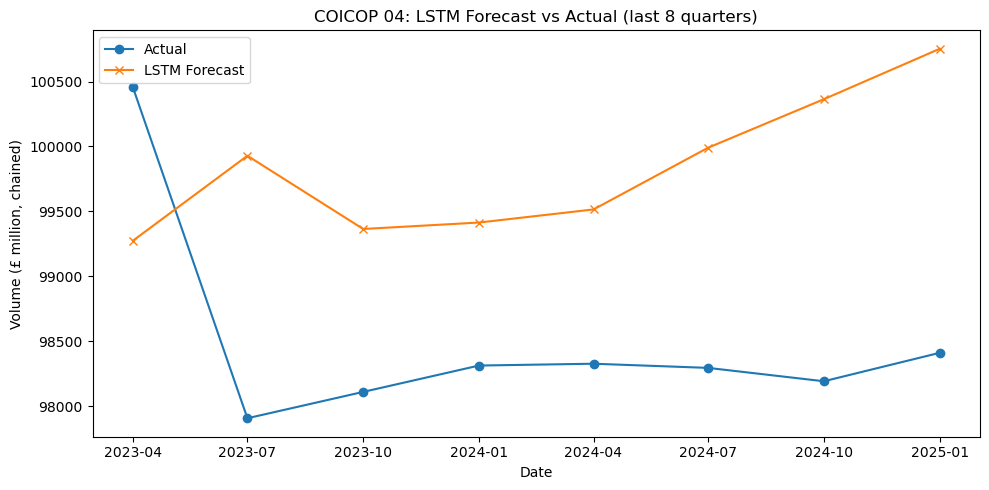

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


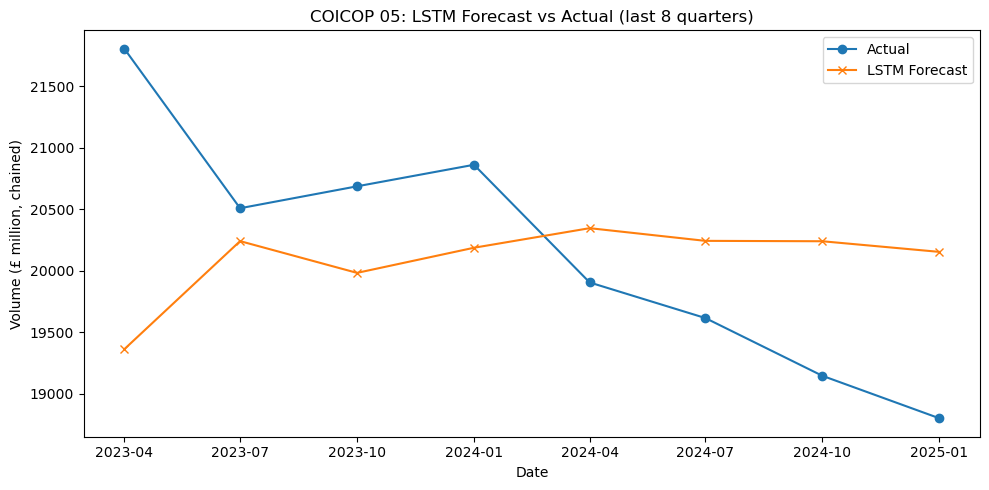

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


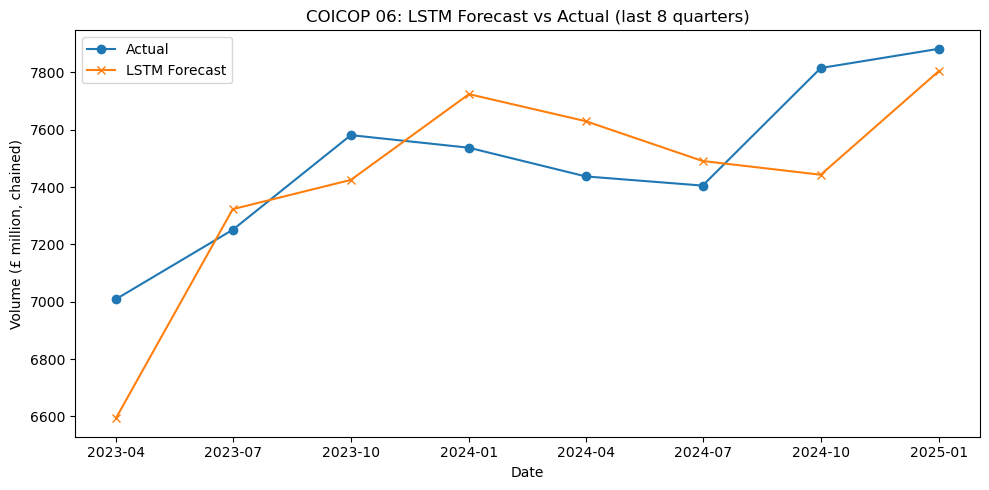

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


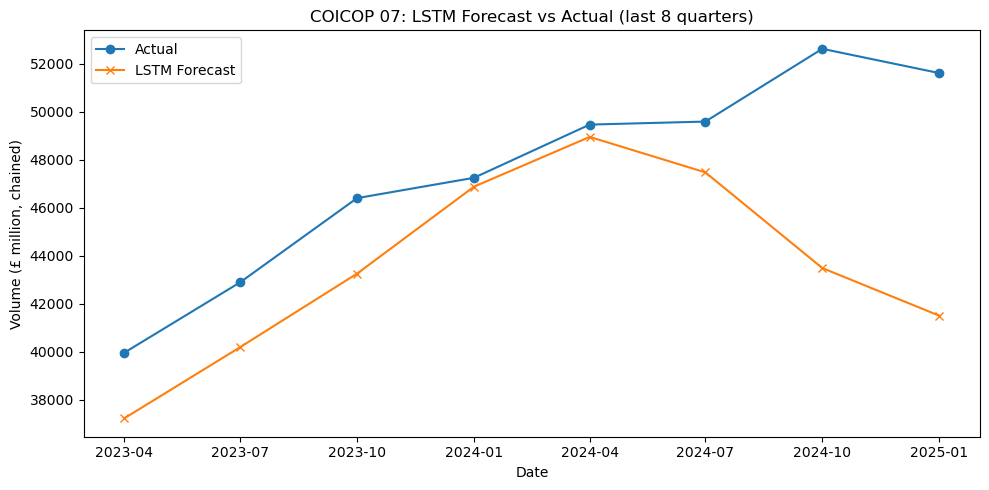

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


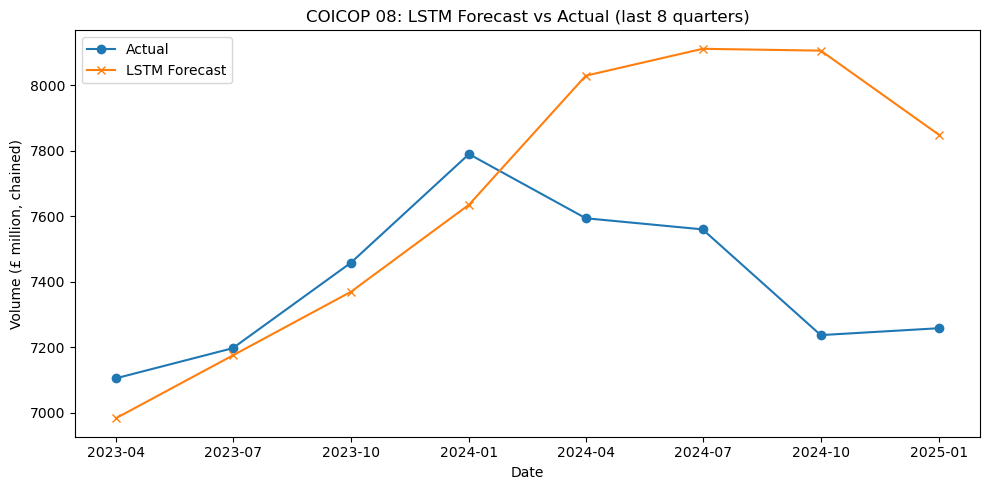

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


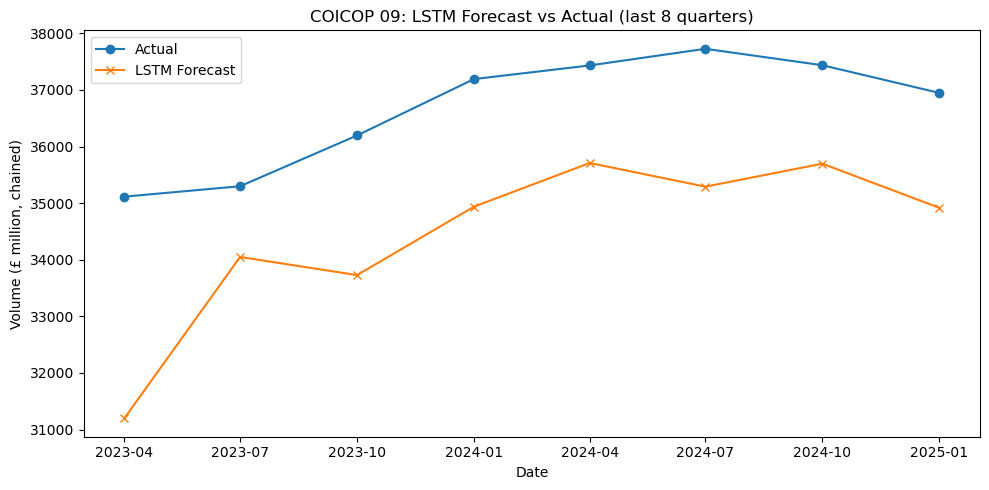

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


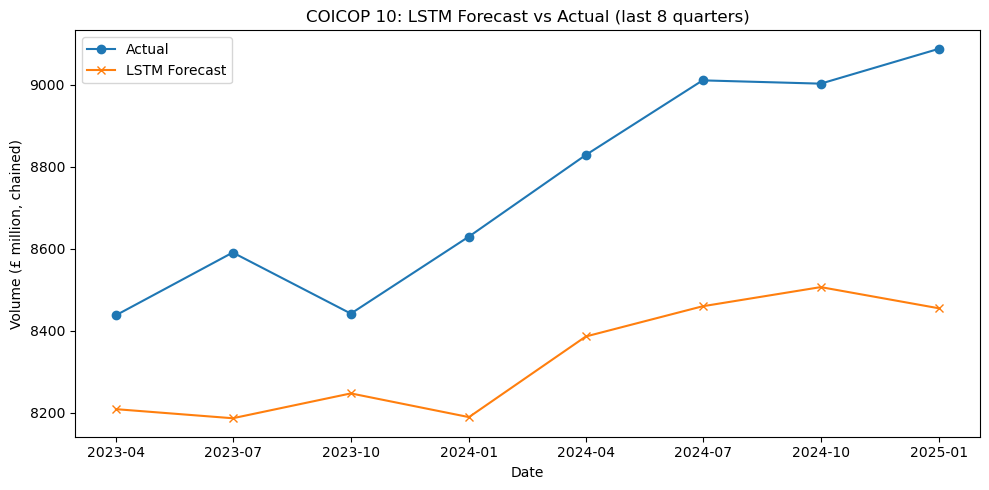

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


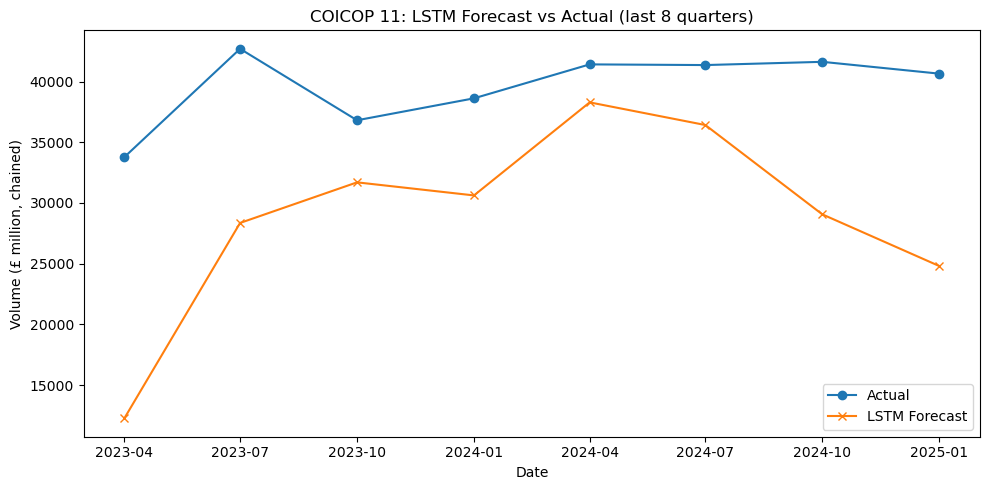

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


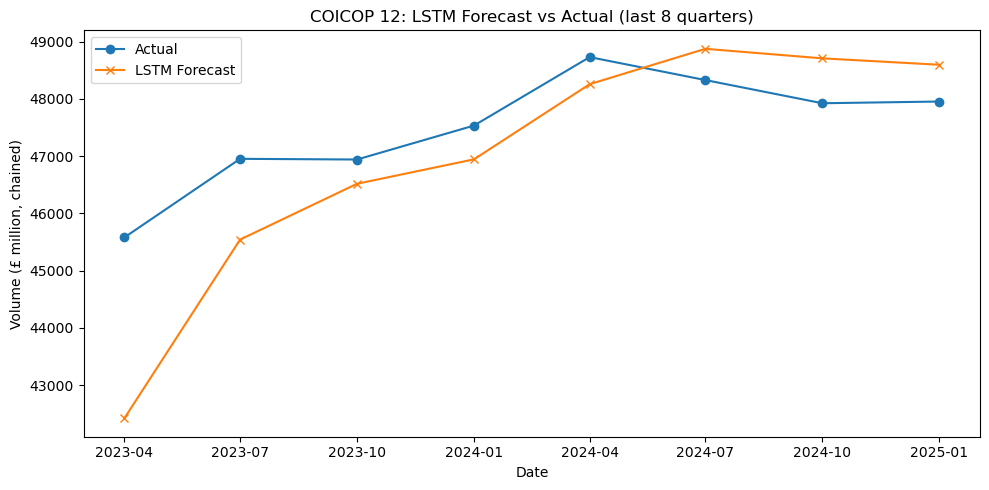


LSTM Model Performance by COICOP (copy-paste ready):

COICOP       MAE      RMSE  MAPE
    01    299.34    399.10  0.93
    02    698.96    781.58  5.70
    03  1,030.63  1,305.74  5.84
    04  1,620.05  1,687.09  1.65
    05    949.53  1,150.01  4.68
    06    194.77    230.73  2.62
    07  3,856.01  5,190.13  7.88
    08    354.44    453.65  4.80
    09  2,226.73  2,347.97  6.10
    10    423.97    446.47  4.81
    11 10,678.54 12,254.03 27.56
    12  1,003.60  1,325.01  2.14


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# --- Load Data ---
CSV_FILE = "Cleaned_Coicop_Data.csv"
df = pd.read_csv(CSV_FILE, parse_dates=['ds'])
df['coicop_base'] = df['coicop_base'].apply(lambda x: f"{int(x):02d}")

lstm_results = []
test_periods = 8  # forecast horizon (quarters)
window = 4       # how many quarters to look back

for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds').reset_index(drop=True)
    if sub.shape[0] <= test_periods + window:
        print(f"Skipping COICOP {code}: not enough data.")
        continue

    data = sub[['volume', 'price', 'deflator', 'unemployment_rate', 'is_holiday']].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(window, len(scaled)-test_periods):
        X.append(scaled[i-window:i, :])
        y.append(scaled[i, 0])  # volume is the first column
    #Last eight quarters are reserved for testing
    X, y = np.array(X), np.array(y)
    X_train, y_train = X[:-test_periods], y[:-test_periods]
    X_test, y_test = X[-test_periods:], y[-test_periods:]

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(32, input_shape=(window, scaled.shape[1]), activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(0.01))

    # Fit model
    es = EarlyStopping(patience=10, restore_best_weights=True) #prevents overfitting
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, callbacks=[es])

    # Predict
    y_pred_scaled = model.predict(X_test).flatten()
    # Inverse transform
    preds_full = np.zeros((len(y_pred_scaled), scaled.shape[1]))
    preds_full[:, 0] = y_pred_scaled
    y_pred = scaler.inverse_transform(preds_full)[:, 0]
    y_true = scaler.inverse_transform(np.concatenate([
        y_test.reshape(-1,1), 
        X_test[:,-1,1:]
    ], axis=1))[:, 0]

    dates_test = sub['ds'].iloc[-test_periods:]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    lstm_results.append({
        'COICOP': code,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'y_true': y_true,
        'y_pred': y_pred,
        'test_dates': dates_test
    })

    plt.figure(figsize=(10,5))
    plt.plot(dates_test, y_true, marker='o', label='Actual')
    plt.plot(dates_test, y_pred, marker='x', label='LSTM Forecast')
    plt.title(f"COICOP {code}: LSTM Forecast vs Actual (last {test_periods} quarters)")
    plt.xlabel("Date")
    plt.ylabel("Volume (£ million, chained)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Results table (copyable) ---
results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k not in ['y_true', 'y_pred', 'test_dates']}
    for d in lstm_results
]).sort_values("COICOP")

summary_table = results_df[['COICOP', 'MAE', 'RMSE', 'MAPE']].round(2)
print("\nLSTM Model Performance by COICOP (copy-paste ready):\n")
print(summary_table.to_string(index=False))


### 4.4 XGBoost Model

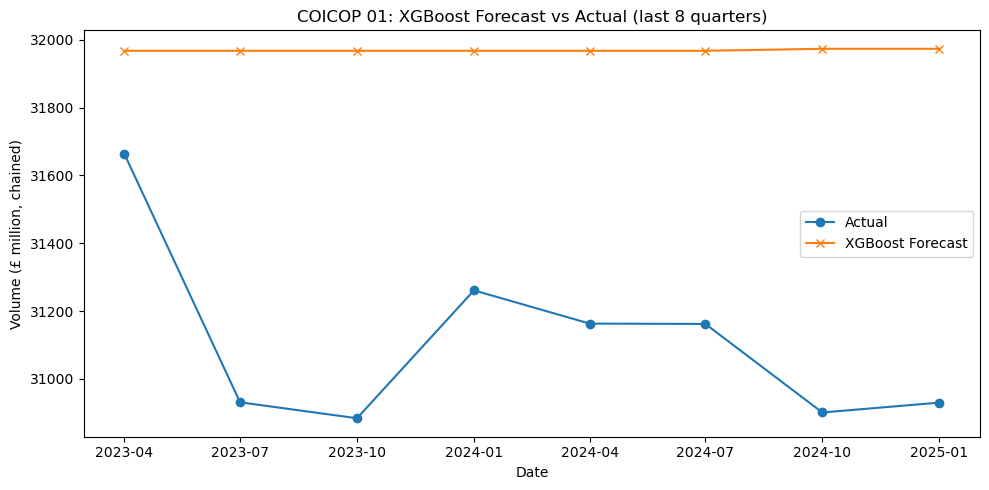

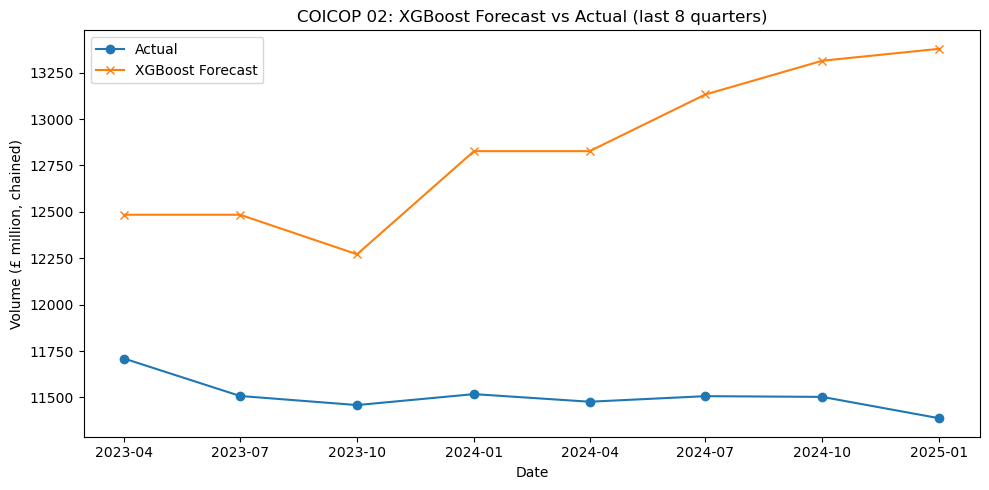

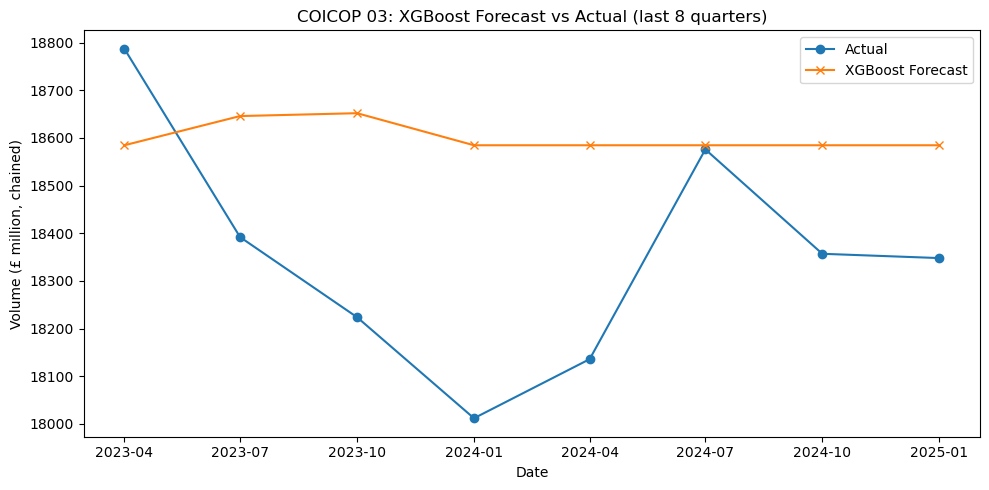

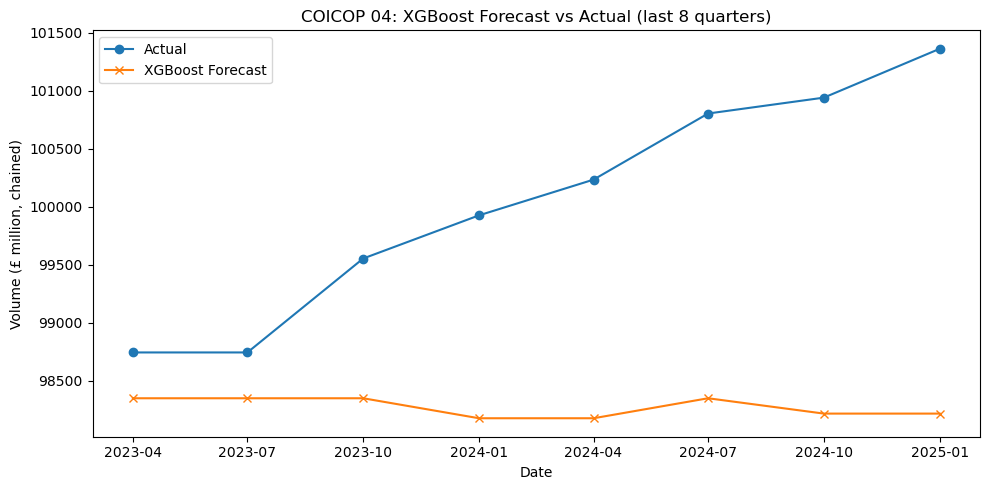

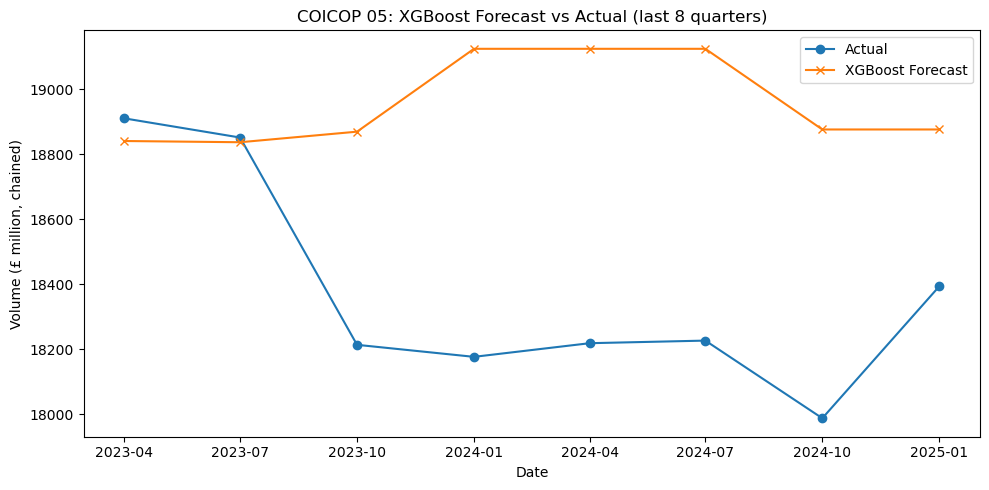

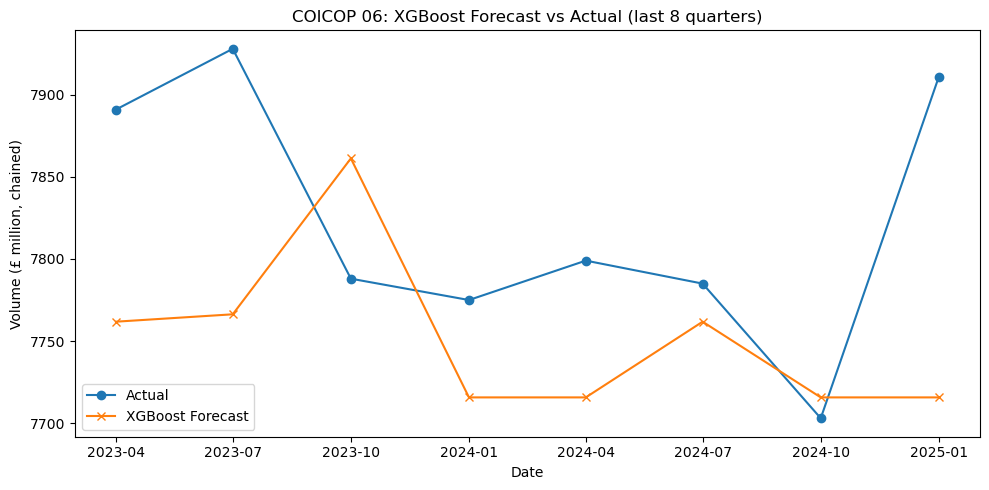

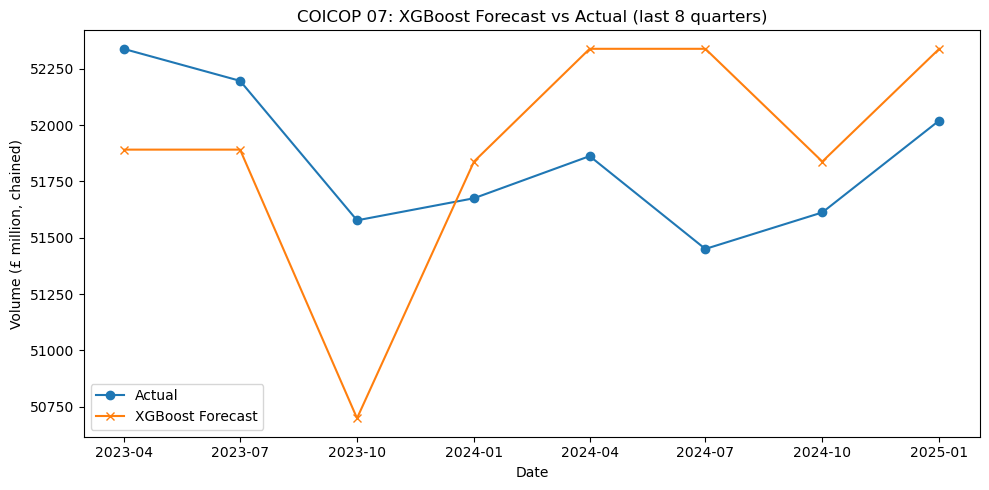

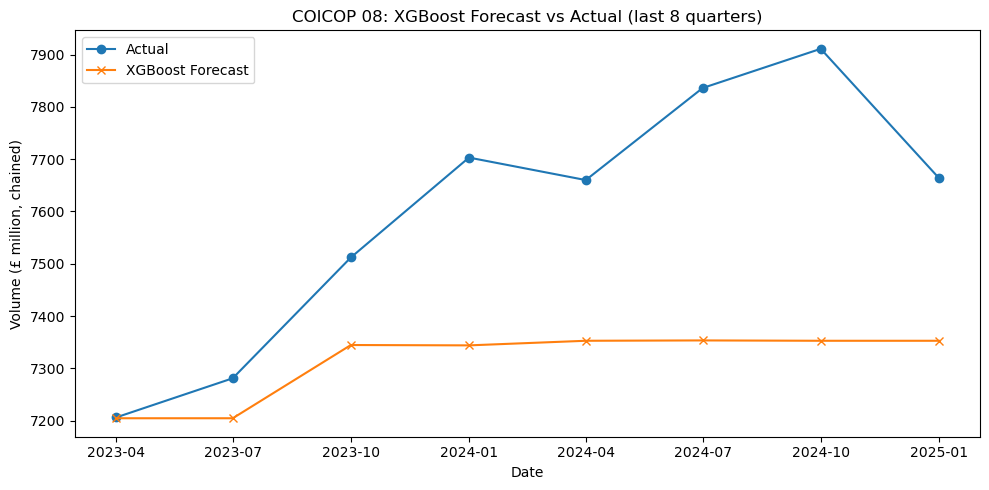

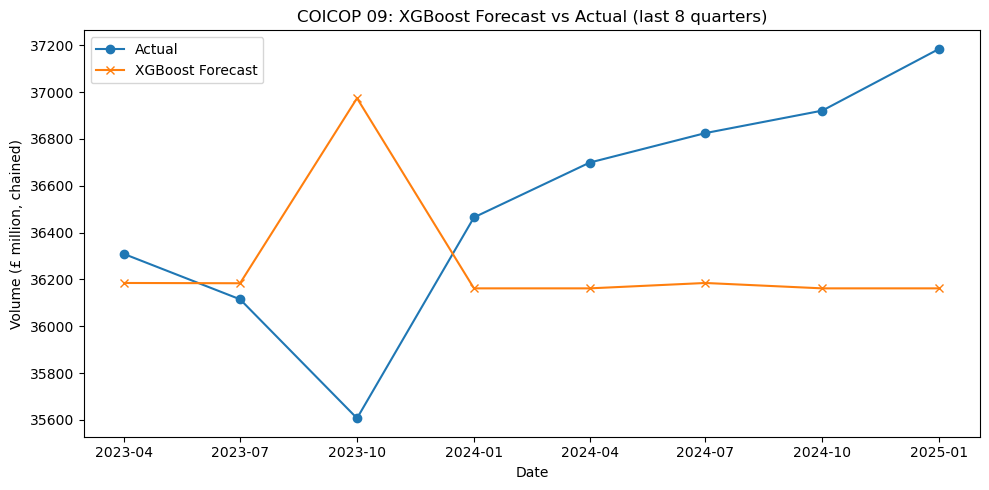

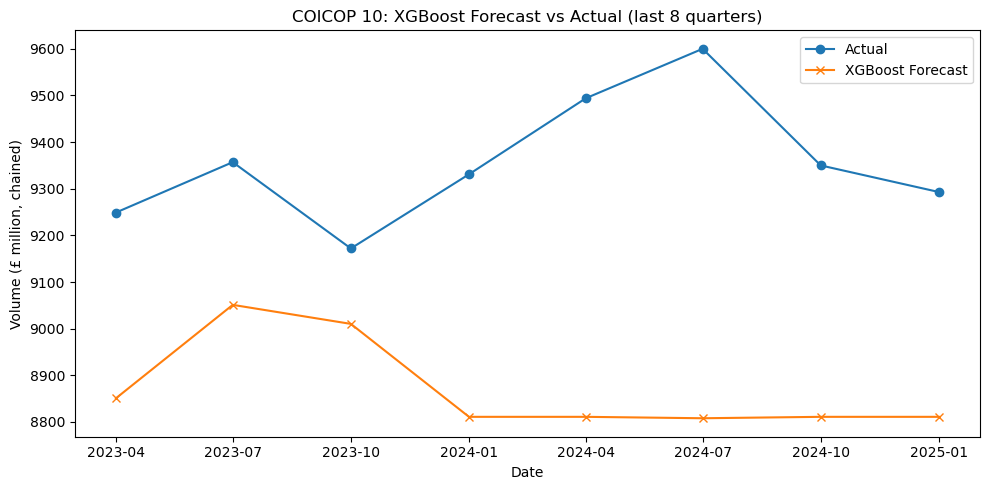

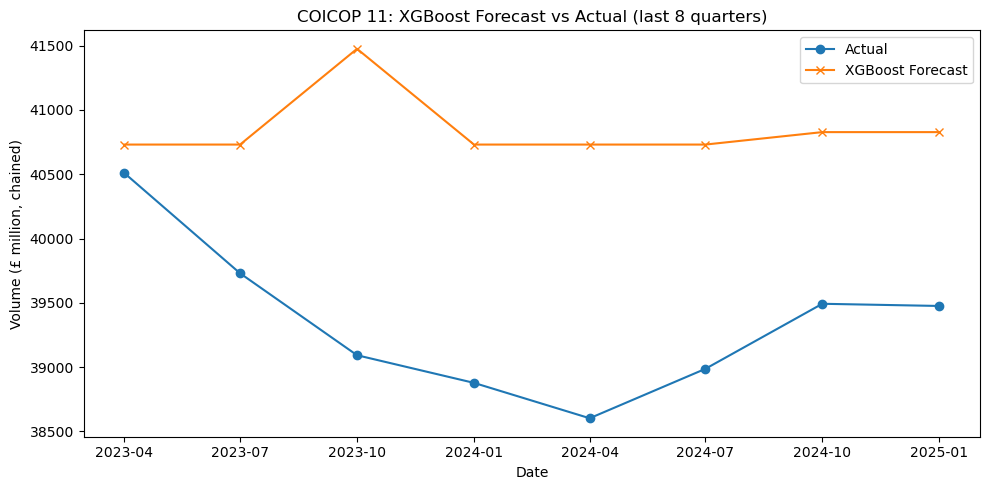

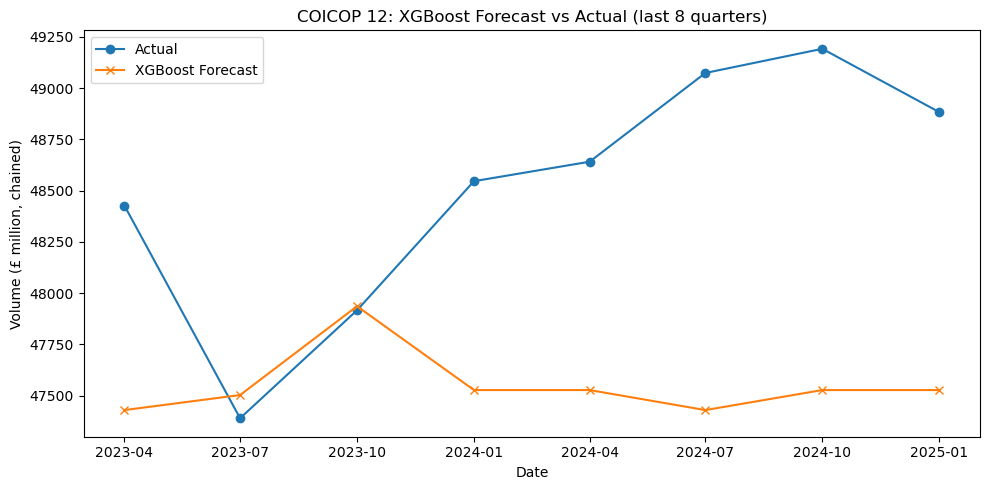


XGBoost Model Performance by COICOP (copy-paste ready):

COICOP      MAE     RMSE  MAPE
    01   856.78   892.36  2.76
    02 1,331.11 1,397.80 11.58
    03   297.31   340.16  1.63
    04 1,765.78 2,012.40  1.76
    05   608.02   705.79  3.34
    06    92.24   110.40  1.17
    07   462.60   531.28  0.89
    08   283.00   335.19  3.66
    09   602.74   733.36  1.65
    10   485.19   520.21  5.16
    11 1,501.98 1,633.11  3.84
    12   991.50 1,151.69  2.03


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# --- Load Data ---
CSV_FILE = "Cleaned_Coicop_Data.csv"
df = pd.read_csv(CSV_FILE, parse_dates=['ds'])
df['coicop_base'] = df['coicop_base'].apply(lambda x: f"{int(x):02d}")

xgb_results = []
test_periods = 8  # quarters for test set

for code in sorted(df['coicop_base'].unique()):
    sub = df[df['coicop_base'] == code].sort_values('ds').reset_index(drop=True)
    if sub.shape[0] <= test_periods + 4:
        print(f"Skipping COICOP {code}: not enough data.")
        continue

    # Feature columns for XGBoost
    feature_cols = ['price', 'deflator', 'unemployment_rate', 'is_holiday']

    X = sub[feature_cols].values
    y = sub['volume'].values

    # Train/test split (like Prophet)
    X_train, y_train = X[:-test_periods], y[:-test_periods]
    X_test, y_test   = X[-test_periods:], y[-test_periods:]
    dates_test = sub['ds'].iloc[-test_periods:]

    # Standardize features for better training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Build and train XGBoost model
    model = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.08, random_state=42)
    model.fit(X_train_scaled, y_train) #using 200 boosting trees, each of depth 3

    # Predict
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    xgb_results.append({
        'COICOP': code,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'y_true': y_test,
        'y_pred': y_pred,
        'test_dates': dates_test
    })

    plt.figure(figsize=(10,5))
    plt.plot(dates_test, y_test, marker='o', label='Actual')
    plt.plot(dates_test, y_pred, marker='x', label='XGBoost Forecast')
    plt.title(f"COICOP {code}: XGBoost Forecast vs Actual (last {test_periods} quarters)")
    plt.xlabel("Date")
    plt.ylabel("Volume (£ million, chained)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Results table  ---
results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k not in ['y_true', 'y_pred', 'test_dates']}
    for d in xgb_results
]).sort_values("COICOP")

summary_table = results_df[['COICOP', 'MAE', 'RMSE', 'MAPE']].round(2)
print("\nXGBoost Model Performance by COICOP (copy-paste ready):\n")
print(summary_table.to_string(index=False))


## 5. Model Comparison and Final Steps

In [ ]:

import pandas as pd
import numpy as np

# This code needs prophet_results, arima_results, lstm_results, xgb_results in the notebook

# Create summary tables for each model
def create_summary_table(results_list):
    """Convert model results to summary dataframe"""
    return pd.DataFrame([
        {k: v for k, v in d.items() if k not in ['y_true', 'y_pred', 'test_dates']}
        for d in results_list
    ]).sort_values("COICOP")

# Create comparison dataframes
prophet_summary = create_summary_table(prophet_results)
arima_summary = create_summary_table(arima_results)
lstm_summary = create_summary_table(lstm_results)
xgb_summary = create_summary_table(xgb_results)

# Adding model labels
prophet_df = prophet_summary.copy()
prophet_df['Model'] = 'Prophet'

arima_df = arima_summary.copy()
arima_df['Model'] = 'ARIMA'

lstm_df = lstm_summary.copy()
lstm_df['Model'] = 'LSTM'

xgb_df = xgb_summary.copy()
xgb_df['Model'] = 'XGBoost'

# Combine all results
all_results = pd.concat([prophet_df, arima_df, lstm_df, xgb_df], axis=0, ignore_index=True)
all_results = all_results[['COICOP', 'Model', 'MAE', 'RMSE', 'MAPE']].sort_values(['COICOP', 'Model'])

# Create pivot table for easy comparison
comparison_pivot = all_results.pivot(index='COICOP', columns='Model', values='MAPE').round(2)

# Display results
print("\n=== Full Model Comparison Table (long format) ===\n")
print(all_results.round(2).to_string(index=False))

print("\n=== MAPE Comparison Table (COICOP × Model, copyable) ===\n")
print(comparison_pivot)

# Save comparison to CSV
all_results.to_csv('model_comparison_results.csv', index=False)
print("\n✅ Model comparison saved to 'model_comparison_results.csv'")



=== Full Model Comparison Table (long format) ===

COICOP   Model       MAE      RMSE  MAPE
    01   ARIMA  1,176.22  1,232.06  3.79
    01    LSTM    299.34    399.10  0.93
    01 Prophet    344.10    372.68  1.11
    01 XGBoost    856.78    892.36  2.76
    02   ARIMA     86.41    108.75  0.75
    02    LSTM    698.96    781.58  5.70
    02 Prophet    315.34    334.40  2.75
    02 XGBoost  1,331.11  1,397.80 11.58
    03   ARIMA  1,080.58  1,137.36  5.91
    03    LSTM  1,030.63  1,305.74  5.84
    03 Prophet    213.09    215.66  1.16
    03 XGBoost    297.31    340.16  1.63
    04   ARIMA  2,367.83  2,632.33  2.36
    04    LSTM  1,620.05  1,687.09  1.65
    04 Prophet    539.11    636.23  0.54
    04 XGBoost  1,765.78  2,012.40  1.76
    05   ARIMA  1,287.89  1,383.60  7.06
    05    LSTM    949.53  1,150.01  4.68
    05 Prophet    220.79    236.28  1.21
    05 XGBoost    608.02    705.79  3.34
    06   ARIMA    174.01    197.29  2.23
    06    LSTM    194.77    230.73  2.62
    0